# Benchmark Results
This notebook visualizes the output from the different models on different classification problems

In [1]:
import collections
import glob
import itertools
import json
import os

import numpy as np
import pandas as pd
import plotnine
import svgutils.transform as sg
from svgutils.compose import SVG, Figure, Panel
from plotnine import *

## Binary Prediction

In [2]:
top_five_tissues = ['Blood', 'Breast', 'Stem_Cell', 'Cervix', 'Brain']

combo_iterator = itertools.combinations(top_five_tissues, 2)
tissue_pairs = [pair for pair in combo_iterator]
tissue_pairs[:3]

[('Blood', 'Breast'), ('Blood', 'Stem_Cell'), ('Blood', 'Cervix')]

In [3]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/{}.{}.*.tsv'.format(pair[0], pair[1])))
len(in_files)

180

In [4]:
run_results = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
    
    tissue1 = run_info[0]
    tissue2 = run_info[1]
    
    model_and_seed = run_info[2].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
    
    correction_method = 'unmodified'
    if 'signal_removed' in path:
        if 'sample_level' in path:
            correction_method = 'signal_removed_sample_level'
        else:
            correction_method = 'signal_removed'
    elif 'study_corrected' in path:
        correction_method = 'study_corrected'
    elif 'split_signal' in path:
        correction_method = 'split_signal'
    
    new_df['Model'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['correction_method'] = correction_method
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    run_results = pd.concat([run_results, new_df])
    
run_results['train_count'] = run_results['train sample count']
run_results['Model'] = run_results['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
run_results['Model'] = run_results['Model'].str.replace('deep_net', 'Five Layer Network')
run_results['Model'] = run_results['Model'].str.replace('pytorch_lr', 'Logistic Regression')

## binary comparisons

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_binary.svg


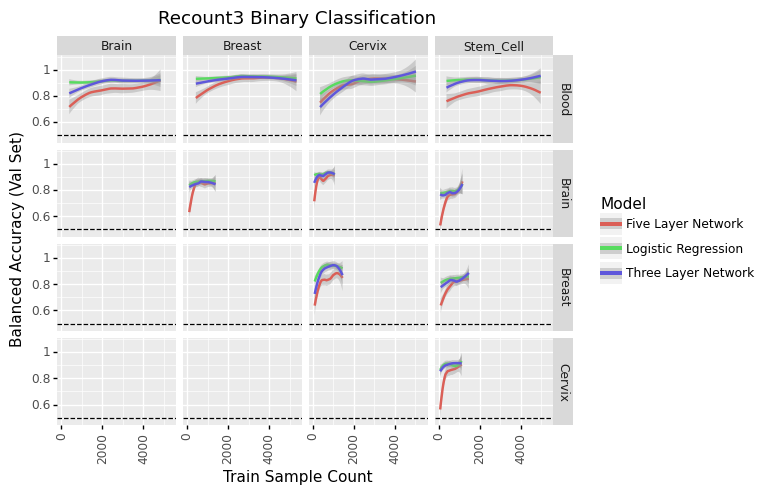

<ggplot: (8772573753837)>

In [5]:
recount_binary_df = run_results[run_results['correction_method'] == 'unmodified']
plot = ggplot(recount_binary_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()

plot += geom_hline(yintercept=.5, linetype='dashed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += ggtitle('Recount3 Binary Classification')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot.save('../../figures/recount_binary.svg')
plot

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_binary_signal_removed.svg


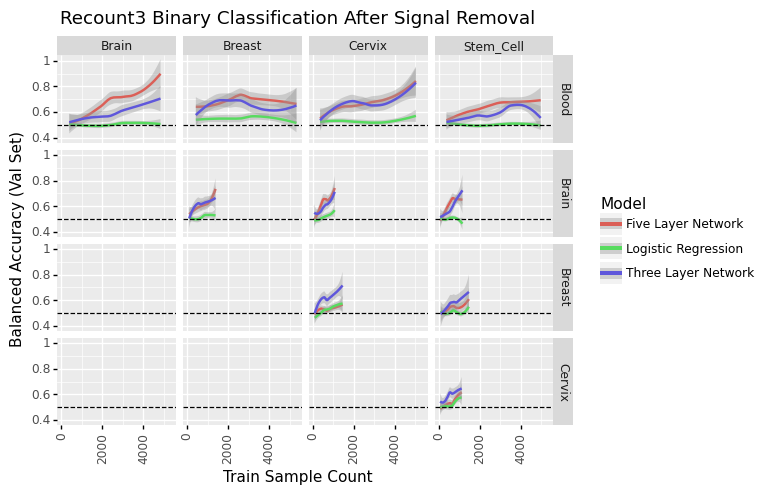

<ggplot: (8772573790941)>

In [6]:
sr_recount_binary_df = run_results[run_results['correction_method'] == 'signal_removed']
plot = ggplot(sr_recount_binary_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')


plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += ggtitle('Recount3 Binary Classification After Signal Removal')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot.save('../../figures/recount_binary_signal_removed.svg')
plot

In [7]:
sr_recount_binary_df = sr_recount_binary_df.loc[:,['balanced_accuracy', 'Model', 'train_count', 'tissue1', 'tissue2']]
sr_recount_binary_df['Correction'] = 'Signal Removed'
recount_binary_df = recount_binary_df.loc[:,['balanced_accuracy', 'Model', 'train_count', 'tissue1', 'tissue2']]
recount_binary_df['Correction'] = 'Full Signal'
combined_df = recount_binary_df.append(sr_recount_binary_df)

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_binary_combined.svg


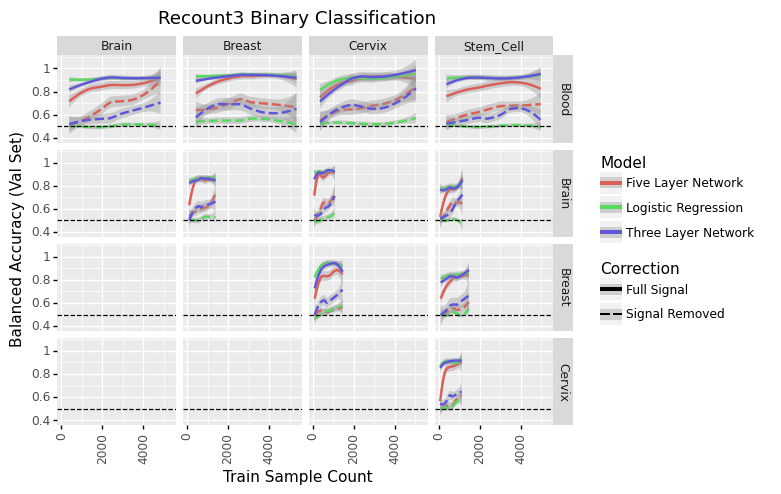

<ggplot: (8772531343517)>

In [8]:
plot = ggplot(combined_df, aes(x='train_count', y='balanced_accuracy', color='Model', linetype='Correction')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')

plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += ggtitle('Recount3 Binary Classification')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot.save('../../figures/recount_binary_combined.svg')
plot

## All Tissue Predictions

In [9]:
in_files = glob.glob('../../results/all-tissue.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/all-tissue.pytorch_lr_2.tsv', '../../results/all-tissue.deep_net_1.tsv', '../../results/all-tissue.logistic_regression_2.tsv', '../../results/all-tissue.pytorch_lr_2_signal_removed.tsv', '../../results/all-tissue.deep_net_2_signal_removed.tsv']


In [10]:
recount_multiclass_df = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    recount_multiclass_df = pd.concat([recount_multiclass_df, new_df])
    
recount_multiclass_df['train_count'] = recount_multiclass_df['train sample count']

recount_multiclass_df['Model'] = recount_multiclass_df['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
recount_multiclass_df['Model'] = recount_multiclass_df['Model'].str.replace('deep_net', 'Five Layer Network')
recount_multiclass_df['Model'] = recount_multiclass_df['Model'].str.replace('pytorch_lr', 'Logistic Regression')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_multiclass.svg


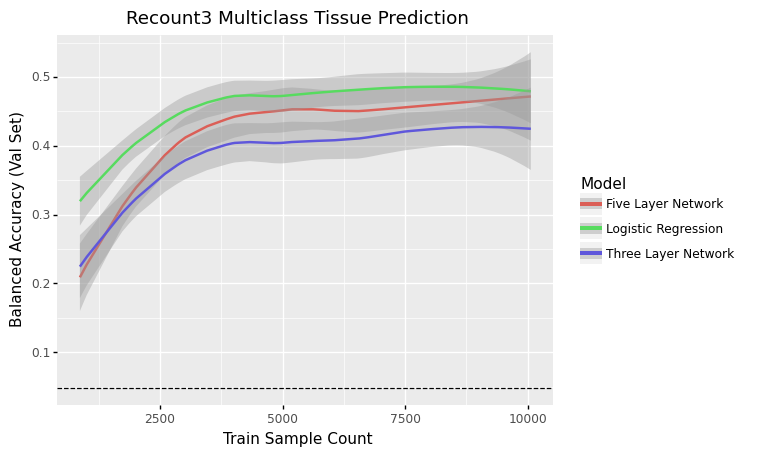

<ggplot: (8772531273601)>

In [11]:
plot_df = recount_multiclass_df
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 

plot += geom_smooth()
plot += geom_hline(yintercept=1/21, linetype='dashed')
plot += ggtitle('Recount3 Multiclass Tissue Prediction')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/recount_multiclass.svg')
plot

### All tissue signal removed

In [12]:
in_files = glob.glob('../../results/all-tissue.*.tsv')
in_files = [f for f in in_files if 'signal_removed' in f]
print(in_files[:5])

['../../results/all-tissue.pytorch_lr_2_signal_removed.tsv', '../../results/all-tissue.deep_net_2_signal_removed.tsv', '../../results/all-tissue.deep_net_1_signal_removed.tsv', '../../results/all-tissue.pytorch_lr_1_signal_removed.tsv', '../../results/all-tissue.pytorch_supervised_2_signal_removed.tsv']


In [13]:
sr_recount_multiclass_df = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-3])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-3]
        
    sr_recount_multiclass_df = pd.concat([sr_recount_multiclass_df, new_df])
    
sr_recount_multiclass_df['train_count'] = sr_recount_multiclass_df['train sample count']

sr_recount_multiclass_df['Model'] = sr_recount_multiclass_df['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
sr_recount_multiclass_df['Model'] = sr_recount_multiclass_df['Model'].str.replace('deep_net', 'Five Layer Network')
sr_recount_multiclass_df['Model'] = sr_recount_multiclass_df['Model'].str.replace('pytorch_lr', 'Logistic Regression')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_multiclass_signal_removed.svg


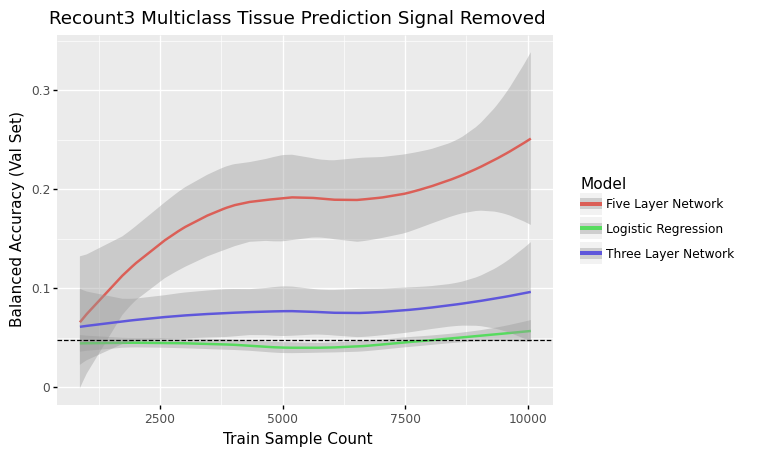

<ggplot: (8772524125809)>

In [14]:
plot_df = sr_recount_multiclass_df
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 

plot += geom_smooth()
plot += geom_hline(yintercept=1/21, linetype='dashed')
plot += ggtitle('Recount3 Multiclass Tissue Prediction Signal Removed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/recount_multiclass_signal_removed.svg')
plot

### Combine recount multiclass figures

In [15]:
sr_recount_multiclass_df = sr_recount_multiclass_df.loc[:,['balanced_accuracy', 'Model', 'train_count']]
sr_recount_multiclass_df['Correction'] = 'Signal Removed'
recount_multiclass_df = recount_multiclass_df.loc[:,['balanced_accuracy', 'Model', 'train_count']]
recount_multiclass_df['Correction'] = 'Full Signal'
combined_df = recount_multiclass_df.append(sr_recount_multiclass_df)
combined_df

,balanced_accuracy,Model,train_count,Correction
0,0.147684,Logistic Regression,963,Full Signal
1,0.408157,Logistic Regression,1927,Full Signal
2,0.414586,Logistic Regression,2890,Full Signal
3,0.423669,Logistic Regression,3854,Full Signal
4,0.439294,Logistic Regression,4818,Full Signal
...,...,...,...,...
45,0.050824,Logistic Regression,6019,Signal Removed
46,0.027584,Logistic Regression,7022,Signal Removed
47,0.047619,Logistic Regression,8025,Signal Removed
48,0.047619,Logistic Regression,9028,Signal Removed


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_multiclass_combined.svg


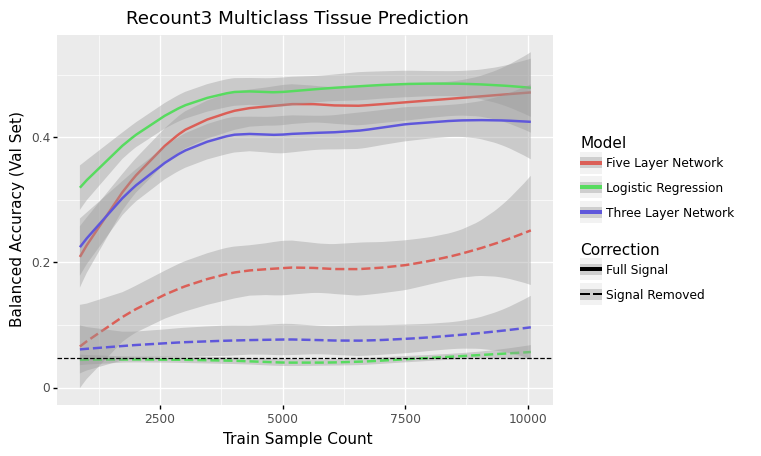

<ggplot: (8772573323761)>

In [16]:
plot_df = combined_df[combined_df['Model']
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model', linetype='Correction')) 

plot += geom_smooth()
plot += geom_hline(yintercept=1/21, linetype='dashed')
plot += ggtitle('Recount3 Multiclass Tissue Prediction')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/recount_multiclass_combined.svg')
plot

## All tissue sample split

In [17]:
in_files = glob.glob('../../results/all-tissue_sample-split*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/all-tissue_sample-split.deep_net_1.tsv', '../../results/all-tissue_sample-split.pytorch_lr_0.tsv', '../../results/all-tissue_sample-split.pytorch_supervised_0.tsv', '../../results/all-tissue_sample-split.deep_net_0.tsv', '../../results/all-tissue_sample-split.pytorch_supervised_2.tsv']


In [18]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue_sample-split.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
    new_df['split'] = 'sample'
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])

In [19]:
more_files = glob.glob('../../results/all-tissue.*')
more_files = [f for f in more_files if 'be_corrected' not in f]
print(more_files[:5])

['../../results/all-tissue.pytorch_lr_2.tsv', '../../results/all-tissue.deep_net_1.tsv', '../../results/all-tissue.logistic_regression_2.tsv', '../../results/all-tissue.pytorch_lr_2_signal_removed.tsv', '../../results/all-tissue.deep_net_2_signal_removed.tsv']


In [20]:
for path in more_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
    new_df['split'] = 'study'
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'Five Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_lr', 'Logistic Regression')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_svm', 'SVM')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('nine_layer_net', 'Nine Layer Network')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_multiclass_sample_split.svg


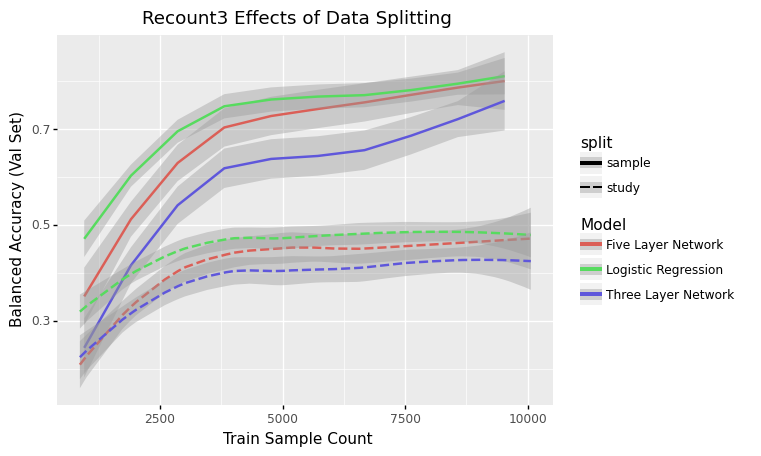

<ggplot: (8772531422641)>

In [21]:
plot_df = tissue_metrics
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth(aes(linetype='split'))
plot += ggtitle('Recount3 Effects of Data Splitting')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/recount_multiclass_sample_split.svg')
plot

## Pretraining

In [22]:
in_files = glob.glob('../../results/study-split.*.tsv')
print(in_files[:5])

['../../results/study-split.pytorch_supervised_2.tsv', '../../results/study-split.deep_net_2.tsv', '../../results/study-split.pytorch_lr_2.tsv', '../../results/study-split.deep_net_0.tsv', '../../results/study-split.pytorch_supervised_1.tsv']


In [23]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv')
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'Five Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_lr', 'Logistic Regression')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_svm', 'SVM')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('nine_layer_net', 'Nine Layer Network')
tissue_metrics['pretrained'] = True
tissue_metrics.loc[tissue_metrics['is_pretrained'] == 'not_pretrained', 'pretrained'] = False
tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,Model,seed,train_count,pretrained
0,0.468627,0.282689,"SRP010678,SRP014620,SRP003021,SRP011233,SRP010...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",478,0.1,pretrained,"11,11,11,11,11,11,6,4,4,4,11,11,11,11,11,3,3,3...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",Three Layer Network,2,478,True
1,0.312857,0.084397,"SRP010678,SRP014620,SRP003021,SRP011233,SRP010...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",478,0.1,not_pretrained,"0,0,0,0,0,0,6,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",Three Layer Network,2,478,False
2,0.503291,0.300654,"SRP010678,SRP014620,SRP035883,SRP003021,SRP011...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",957,0.2,pretrained,"11,11,11,11,11,5,5,4,4,4,6,6,4,4,4,3,3,3,3,3,6...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",Three Layer Network,2,957,True
3,0.424309,0.047619,"SRP010678,SRP014620,SRP035883,SRP003021,SRP011...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",957,0.2,not_pretrained,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",Three Layer Network,2,957,False
4,0.519087,0.283848,"SRP010678,SRP014620,SRP033569,SRP035883,SRP003...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",1435,0.3,pretrained,"11,11,11,11,11,11,9,4,4,4,11,11,4,4,4,3,3,3,3,...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",Three Layer Network,2,1435,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.134600,0.095473,"SRP042620,SRP015845,SRP059172,SRP028612,SRP035...","SRR357235,SRR521454,SRR1521364,SRR1521399,SRR5...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",4111,0.8,not_pretrained,"13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,1...","3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",Logistic Regression,1,4111,False
96,0.313143,0.340958,"SRP042620,SRP015845,SRP059172,SRP028612,SRP035...","SRR357235,SRR521454,SRR1521364,SRR1521399,SRR5...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",4625,0.9,pretrained,"16,16,16,16,16,16,16,16,16,16,16,16,16,13,13,1...","3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",Logistic Regression,1,4625,True
97,0.263658,0.104306,"SRP042620,SRP015845,SRP059172,SRP028612,SRP035...","SRR357235,SRR521454,SRR1521364,SRR1521399,SRR5...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",4625,0.9,not_pretrained,"13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,1...","3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",Logistic Regression,1,4625,False
98,0.499208,0.360101,"SRP042620,SRP015845,SRP026089,SRP059172,SRP028...","SRR357235,SRR521454,SRR1521364,SRR1521399,SRR5...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",5139,1.0,pretrained,"7,13,13,13,13,13,13,13,7,13,13,13,13,13,13,13,...","3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",Logistic Regression,1,5139,True


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_pretraining.svg


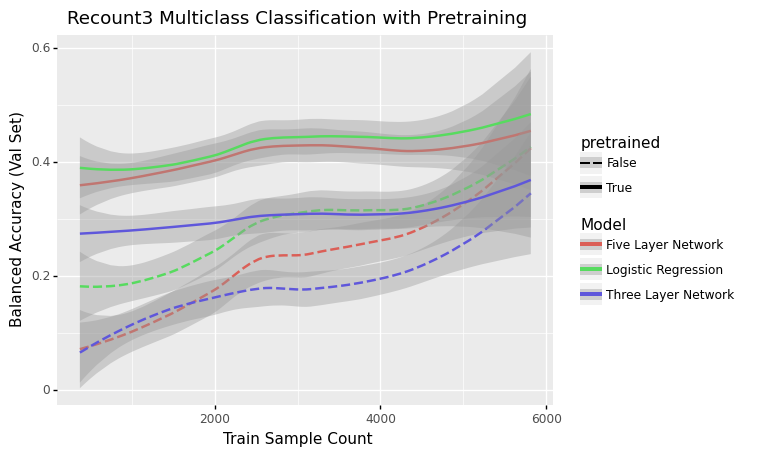

<ggplot: (8772531114881)>

In [24]:
plot_df = tissue_metrics
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth(aes(linetype='pretrained'))
plot += ggtitle('Recount3 Multiclass Classification with Pretraining')
plot += scale_linetype_manual(['dashed', 'solid'])
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/recount_pretraining.svg')
plot

## Sex Prediction

### Study Level

In [25]:
in_files = glob.glob('../../results/study-split-sex-prediction.*.tsv')
print(in_files[:5])

['../../results/study-split-sex-prediction.pytorch_lr_1.tsv', '../../results/study-split-sex-prediction.pytorch_supervised_1.tsv', '../../results/study-split-sex-prediction.pytorch_supervised_0.tsv', '../../results/study-split-sex-prediction.pytorch_lr_2.tsv', '../../results/study-split-sex-prediction.deep_net_2.tsv']


In [26]:
sex_prediction_df = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    sex_prediction_df = pd.concat([sex_prediction_df, new_df])
    
sex_prediction_df['train_count'] = sex_prediction_df['train sample count']
sex_prediction_df['Model'] = sex_prediction_df['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
sex_prediction_df['Model'] = sex_prediction_df['Model'].str.replace('deep_net', 'Five Layer Network')
sex_prediction_df['Model'] = sex_prediction_df['Model'].str.replace('pytorch_lr', 'Logistic Regression')

sex_prediction_df

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,Model,seed,train_count
0,0.757891,0.761315,"ERP001458,SRP017262,SRP154566,SRP056612,SRP115...","SRR1296055,SRR1987677,ERR1806314,SRR4241424,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",1756,0.1,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",Logistic Regression,1,1756
1,0.820349,0.826195,"ERP001458,SRP017262,SRP154566,SRP056612,SRP115...","SRR1296055,SRR1987677,ERR1806314,SRR4241424,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",3513,0.2,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",Logistic Regression,1,3513
2,0.821189,0.816641,"ERP001458,SRP017262,SRP154566,SRP056612,SRP115...","SRR1296055,SRR1987677,ERR1806314,SRR4241424,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",5270,0.3,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",Logistic Regression,1,5270
3,0.863499,0.860018,"ERP001458,SRP017262,SRP154566,SRP056612,SRP115...","SRR1296055,SRR1987677,ERR1806314,SRR4241424,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",7027,0.4,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",Logistic Regression,1,7027
4,0.847213,0.849006,"ERP001458,SRP017262,SRP154566,SRP056612,SRP115...","SRR1296055,SRR1987677,ERR1806314,SRR4241424,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",8784,0.5,"0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",Logistic Regression,1,8784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.856948,0.857089,"SRP071758,SRP070710,SRP075396,SRP077046,SRP096...","ERR1991712,SRR5981882,SRR1282972,SRR3031922,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",11916,0.6,"0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",Three Layer Network,2,11916
46,0.770407,0.775045,"SRP071758,SRP070710,SRP075396,SRP077046,SRP096...","ERR1991712,SRR5981882,SRR1282972,SRR3031922,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",13902,0.7,"1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,1,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",Three Layer Network,2,13902
47,0.754573,0.763809,"SRP071758,SRP070710,SRP075396,SRP077046,SRP096...","ERR1991712,SRR5981882,SRR1282972,SRR3031922,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",15888,0.8,"0,1,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",Three Layer Network,2,15888
48,0.747748,0.751924,"SRP071758,SRP070710,SRP075396,SRP077046,SRP096...","ERR1991712,SRR5981882,SRR1282972,SRR3031922,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",17874,0.9,"1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,0,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",Three Layer Network,2,17874


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sex_prediction.svg


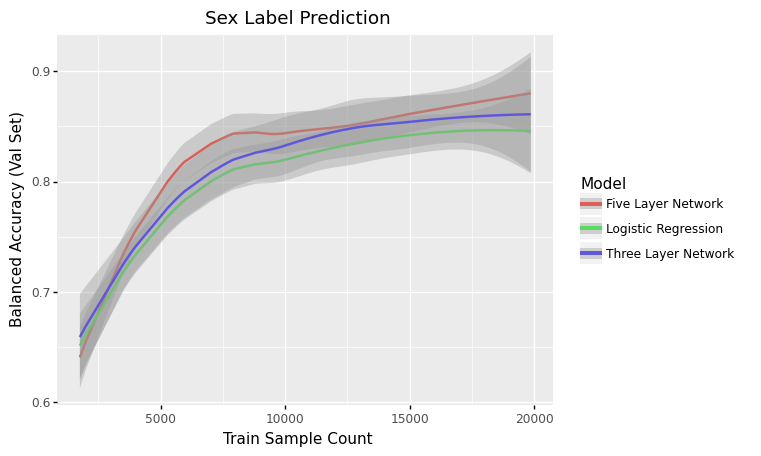

<ggplot: (8772531524565)>

In [27]:
plot_df = sex_prediction_df
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += ggtitle('Sex Label Prediction')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sex_prediction.svg')
plot

### Study level signal removed

In [28]:
in_files = glob.glob('../../results/sex-prediction-signal-removed.*.tsv')
print(in_files[:5])

['../../results/sex-prediction-signal-removed.deep_net_1.tsv', '../../results/sex-prediction-signal-removed.pytorch_supervised_2.tsv', '../../results/sex-prediction-signal-removed.pytorch_lr_1.tsv', '../../results/sex-prediction-signal-removed.deep_net_0.tsv', '../../results/sex-prediction-signal-removed.pytorch_lr_2.tsv']


In [29]:
sr_sex_prediction_df = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sex-prediction-signal-removed.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    sr_sex_prediction_df = pd.concat([sr_sex_prediction_df, new_df])
    
sr_sex_prediction_df['train_count'] = sr_sex_prediction_df['train sample count']
sr_sex_prediction_df['Model'] = sr_sex_prediction_df['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
sr_sex_prediction_df['Model'] = sr_sex_prediction_df['Model'].str.replace('deep_net', 'Five Layer Network')
sr_sex_prediction_df['Model'] = sr_sex_prediction_df['Model'].str.replace('pytorch_lr', 'Logistic Regression')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sex_prediction_signal_removed.svg


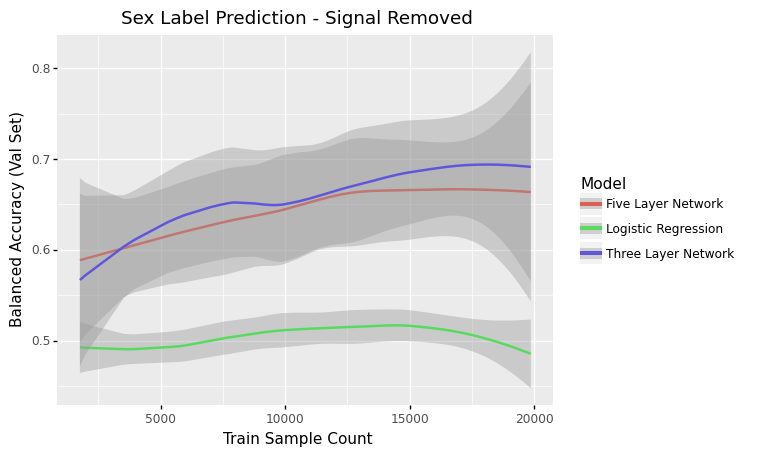

<ggplot: (8772529567573)>

In [30]:
plot_df = sr_sex_prediction_df
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += ggtitle('Sex Label Prediction - Signal Removed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sex_prediction_signal_removed.svg')
plot

### Combine plots

In [31]:
sr_sex_prediction_df = sr_sex_prediction_df.loc[:,['balanced_accuracy', 'Model', 'train_count']]
sr_sex_prediction_df['Correction'] = 'Signal Removed'
sex_prediction_df = sex_prediction_df.loc[:,['balanced_accuracy', 'Model', 'train_count']]
sex_prediction_df['Correction'] = 'Full Signal'
combined_df = sex_prediction_df.append(sr_sex_prediction_df)
combined_df

,balanced_accuracy,Model,train_count,Correction
0,0.761315,Logistic Regression,1756,Full Signal
1,0.826195,Logistic Regression,3513,Full Signal
2,0.816641,Logistic Regression,5270,Full Signal
3,0.860018,Logistic Regression,7027,Full Signal
4,0.849006,Logistic Regression,8784,Full Signal
...,...,...,...,...
45,0.474182,Five Layer Network,11916,Signal Removed
46,0.459796,Five Layer Network,13902,Signal Removed
47,0.519185,Five Layer Network,15888,Signal Removed
48,0.465082,Five Layer Network,17874,Signal Removed


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sex_prediction_combined.svg


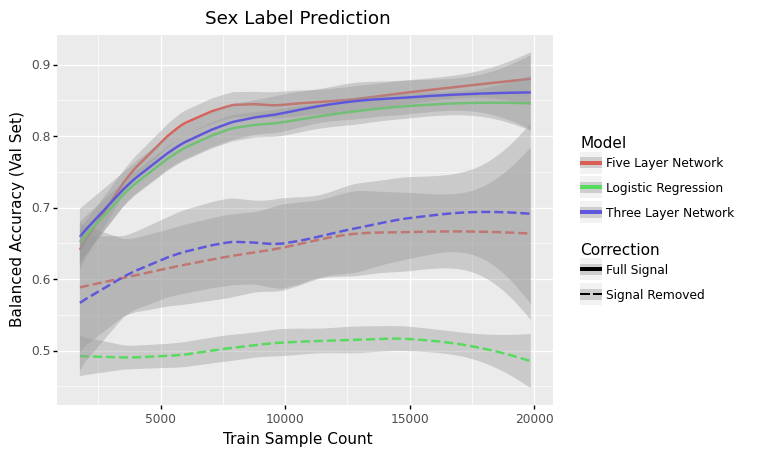

<ggplot: (8772531549861)>

In [32]:
plot_df = combined_df
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model', linetype='Correction')) 
plot += geom_smooth()
plot += ggtitle('Sex Label Prediction')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sex_prediction_combined.svg')
plot

## GTEx All Tissues

In [33]:
in_files = glob.glob('../../results/gtex-all-tissue.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/gtex-all-tissue.deep_net_1.tsv', '../../results/gtex-all-tissue.deep_net_0.tsv', '../../results/gtex-all-tissue.pytorch_lr_0.tsv', '../../results/gtex-all-tissue.pytorch_supervised_1.tsv', '../../results/gtex-all-tissue.deep_net_2.tsv']


In [34]:
gtex_multiclass_df = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    gtex_multiclass_df = pd.concat([gtex_multiclass_df, new_df])
    
gtex_multiclass_df['train_count'] = gtex_multiclass_df['train sample count']

gtex_multiclass_df['Model'] = gtex_multiclass_df['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
gtex_multiclass_df['Model'] = gtex_multiclass_df['Model'].str.replace('deep_net', 'Five Layer Network')
gtex_multiclass_df['Model'] = gtex_multiclass_df['Model'].str.replace('pytorch_lr', 'Logistic Regression')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/gtex_multiclass.svg


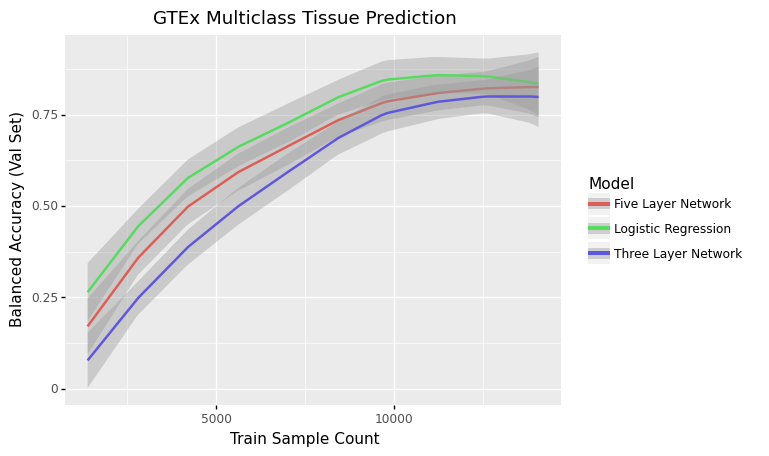

<ggplot: (8772524032505)>

In [35]:
plot_df = gtex_multiclass_df
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
#plot += geom_point(alpha=.2)
plot += ggtitle('GTEx Multiclass Tissue Prediction')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/gtex_multiclass.svg')
plot

In [36]:
in_files = glob.glob('../../results/gtex-all-tissue-signal-removed.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/gtex-all-tissue-signal-removed.pytorch_lr_0.tsv', '../../results/gtex-all-tissue-signal-removed.pytorch_supervised_0.tsv', '../../results/gtex-all-tissue-signal-removed.pytorch_supervised_1.tsv', '../../results/gtex-all-tissue-signal-removed.pytorch_supervised_2.tsv', '../../results/gtex-all-tissue-signal-removed.deep_net_2.tsv']


In [37]:
sr_gtex_multiclass_df = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('gtex-all-tissue-signal-removed.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    sr_gtex_multiclass_df = pd.concat([sr_gtex_multiclass_df, new_df])
    
sr_gtex_multiclass_df['train_count'] = sr_gtex_multiclass_df['train sample count']

sr_gtex_multiclass_df['Model'] = sr_gtex_multiclass_df['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
sr_gtex_multiclass_df['Model'] = sr_gtex_multiclass_df['Model'].str.replace('deep_net', 'Five Layer Network')
sr_gtex_multiclass_df['Model'] = sr_gtex_multiclass_df['Model'].str.replace('pytorch_lr', 'Logistic Regression')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/gtex_multiclass_signal_removed.svg


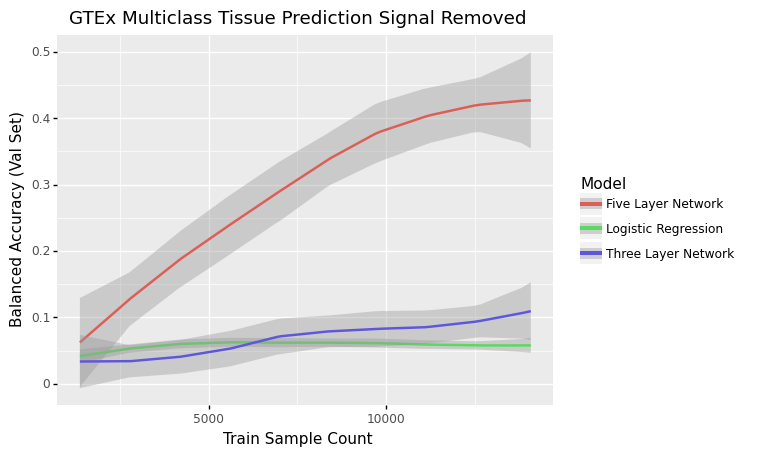

<ggplot: (8772523968529)>

In [38]:
plot_df = sr_gtex_multiclass_df
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += ggtitle('GTEx Multiclass Tissue Prediction Signal Removed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/gtex_multiclass_signal_removed.svg')
plot

In [39]:
sr_gtex_multiclass_df = sr_gtex_multiclass_df.loc[:,['balanced_accuracy', 'Model', 'train_count']]
sr_gtex_multiclass_df['Correction'] = 'Signal Removed'
gtex_multiclass_df = gtex_multiclass_df.loc[:,['balanced_accuracy', 'Model', 'train_count']]
gtex_multiclass_df['Correction'] = 'Full Signal'
combined_df = gtex_multiclass_df.append(sr_gtex_multiclass_df)
combined_df

,balanced_accuracy,Model,train_count,Correction
0,0.017619,Five Layer Network,1394,Full Signal
1,0.087602,Five Layer Network,2789,Full Signal
2,0.579543,Five Layer Network,4183,Full Signal
3,0.203063,Five Layer Network,5578,Full Signal
4,0.678210,Five Layer Network,6973,Full Signal
...,...,...,...,...
45,0.066010,Logistic Regression,8311,Signal Removed
46,0.050115,Logistic Regression,9697,Signal Removed
47,0.034752,Logistic Regression,11082,Signal Removed
48,0.033321,Logistic Regression,12467,Signal Removed


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/gtex_multiclass_combined.svg


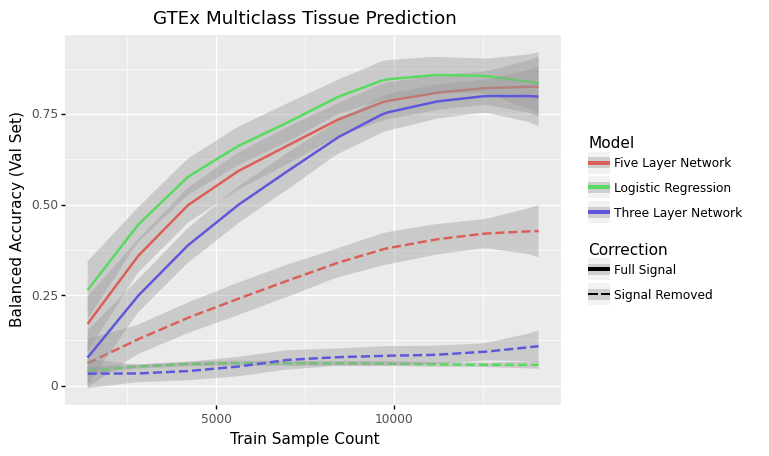

<ggplot: (8772524649709)>

In [40]:
plot_df = combined_df
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model', linetype='Correction')) 
plot += geom_smooth()
plot += ggtitle('GTEx Multiclass Tissue Prediction')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/gtex_multiclass_combined.svg')
plot

## Binary Predictions

In [41]:
top_five_tissues = ['Blood', 'Brain', 'Skin', 'Esophagus', 'Blood_Vessel']

combo_iterator = itertools.combinations(top_five_tissues, 2)
tissue_pairs = [pair for pair in combo_iterator]
tissue_pairs[:3]

[('Blood', 'Brain'), ('Blood', 'Skin'), ('Blood', 'Esophagus')]

In [42]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/gtex.{}.{}.*.tsv'.format(pair[0], pair[1])))
len(in_files)

90

In [43]:
gtex_binary_df = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
        
    tissue1 = run_info[1]
    tissue2 = run_info[2]
    
    model_and_seed = run_info[3].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
    
    correction_method = 'unmodified'
    if 'signal_removed' in path:
        if 'sample_level' in path:
            correction_method = 'signal_removed_sample_level'
        else:
            correction_method = 'signal_removed'
    elif 'study_corrected' in path:
        correction_method = 'study_corrected'
    elif 'split_signal' in path:
        correction_method = 'split_signal'
    
    new_df['Model'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['correction_method'] = correction_method
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    gtex_binary_df = pd.concat([gtex_binary_df, new_df])
    
gtex_binary_df['train_count'] = gtex_binary_df['train sample count']
gtex_binary_df['Model'] = gtex_binary_df['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
gtex_binary_df['Model'] = gtex_binary_df['Model'].str.replace('deep_net', 'Five Layer Network')
gtex_binary_df['Model'] = gtex_binary_df['Model'].str.replace('pytorch_lr', 'Logistic Regression')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/gtex_binary.svg


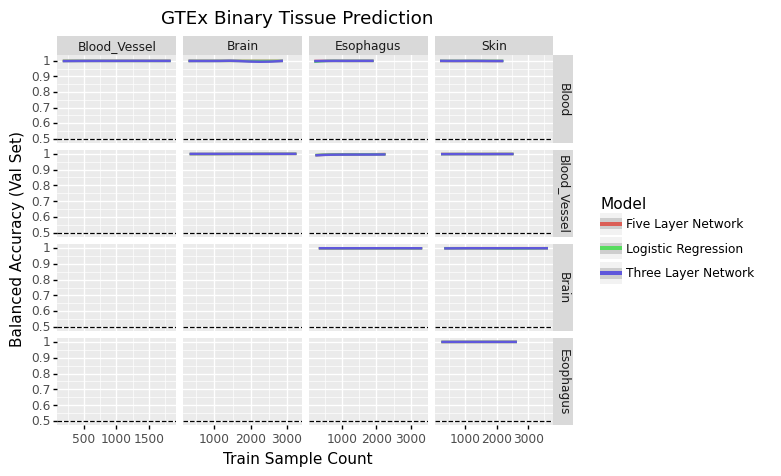

<ggplot: (8772523902085)>

In [44]:
plot_df = gtex_binary_df
plot_df = plot_df[plot_df['correction_method'] == 'unmodified']
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += facet_grid(['tissue1', 'tissue2'], scales='free')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += ggtitle('GTEx Binary Tissue Prediction')
plot.save('../../figures/gtex_binary.svg')
plot

In [45]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/gtex-signal-removed.{}.{}.*.tsv'.format(pair[0], pair[1])))
len(in_files)

90

In [46]:
sr_gtex_binary_df = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
        
    tissue1 = run_info[1]
    tissue2 = run_info[2]
    
    model_and_seed = run_info[3].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
        
    new_df['Model'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    sr_gtex_binary_df = pd.concat([sr_gtex_binary_df, new_df])
    
sr_gtex_binary_df['train_count'] = sr_gtex_binary_df['train sample count']
sr_gtex_binary_df['Model'] = sr_gtex_binary_df['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
sr_gtex_binary_df['Model'] = sr_gtex_binary_df['Model'].str.replace('deep_net', 'Five Layer Network')
sr_gtex_binary_df['Model'] = sr_gtex_binary_df['Model'].str.replace('pytorch_lr', 'Logistic Regression')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/gtex_binary_signal_removed.svg


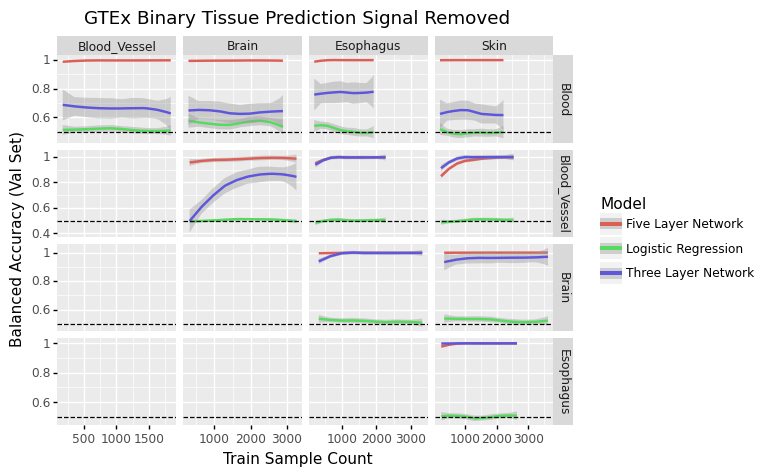

<ggplot: (8772531098569)>

In [47]:
plot_df = sr_gtex_binary_df
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += facet_grid(['tissue1', 'tissue2'], scales='free')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += ggtitle('GTEx Binary Tissue Prediction Signal Removed')
plot.save('../../figures/gtex_binary_signal_removed.svg')
plot

In [48]:
sr_gtex_binary_df = sr_gtex_binary_df.loc[:,['balanced_accuracy', 'Model', 'train_count', 'tissue1', 'tissue2']]
sr_gtex_binary_df['Correction'] = 'Signal Removed'
gtex_binary_df = gtex_binary_df.loc[:,['balanced_accuracy', 'Model', 'train_count', 'tissue1', 'tissue2']]
gtex_binary_df['Correction'] = 'Full Signal'
combined_df = gtex_binary_df.append(sr_gtex_binary_df)

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/gtex_binary_combined.svg


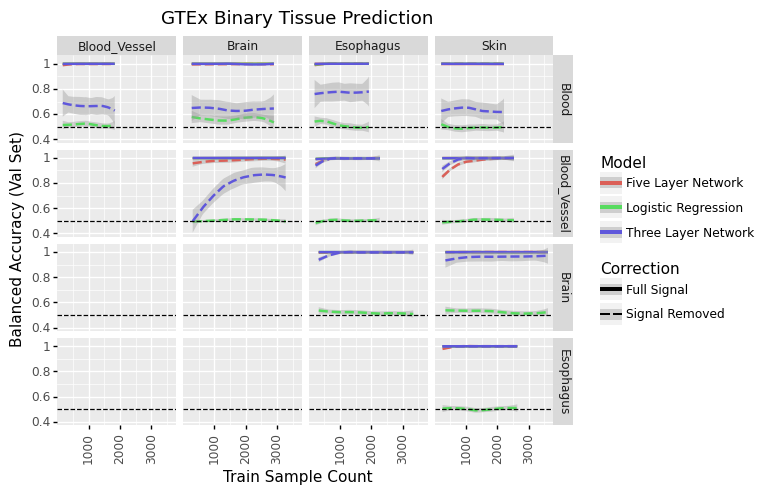

<ggplot: (8772531273569)>

In [49]:
plot = ggplot(combined_df, aes(x='train_count', y='balanced_accuracy', color='Model', linetype='Correction')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += ggtitle('GTEx Binary Tissue Prediction')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot.save('../../figures/gtex_binary_combined.svg')
plot

### Combine GTEx

In [50]:
#create new SVG figure
fig = sg.SVGFigure("16cm", "16cm")

# load matpotlib-generated figures
fig1 = sg.fromfile('../../figures/gtex_multiclass.svg')
fig2 = sg.fromfile('../../figures/gtex_multiclass_signal_removed.svg')
fig3 = sg.fromfile('../../figures/gtex_binary.svg')
fig4 = sg.fromfile('../../figures/gtex_binary_signal_removed.svg')

plot1 = fig1.getroot()
plot3 = fig2.getroot()
plot2 = fig3.getroot()
plot4 = fig4.getroot()

plot1.moveto(0, 0, scale_x=.5, scale_y=.5)
plot2.moveto(0, 162, scale_x=.5, scale_y=.5)
plot3.moveto(210, 0, scale_x=.5, scale_y=.5)
plot4.moveto(210, 162, scale_x=.5, scale_y=.5)

fig.append([plot1, plot2, plot3, plot4])

fig.save('../../figures/gtex_combined.svg')

## Simulated data 

In [2]:
in_files = glob.glob('../../results/sim-data.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/sim-data.deep_net_2.tsv', '../../results/sim-data.pytorch_supervised_0.tsv', '../../results/sim-data.nine_layer_net_1.tsv', '../../results/sim-data.deep_net_1.tsv', '../../results/sim-data.pytorch_lr_0.tsv']


In [9]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'Five Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_lr', 'Logistic Regression')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_svm', 'SVM')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('nine_layer_net', 'Nine Layer Network')

In [10]:
tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,Model,seed,train_count
0,0.995,0.994737,"sample_73_study,sample_222_study,sample_836_st...","sample_128,sample_783,sample_73,sample_271,sam...","sample_7,sample_8,sample_13,sample_16,sample_2...",80,0.1,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",Five Layer Network,2,80
1,1.000,1.000000,"sample_73_study,sample_718_study,sample_222_st...","sample_128,sample_783,sample_73,sample_271,sam...","sample_7,sample_8,sample_13,sample_16,sample_2...",160,0.2,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",Five Layer Network,2,160
2,1.000,1.000000,"sample_792_study,sample_73_study,sample_718_st...","sample_128,sample_783,sample_73,sample_271,sam...","sample_7,sample_8,sample_13,sample_16,sample_2...",240,0.3,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",Five Layer Network,2,240
3,1.000,1.000000,"sample_222_study,sample_690_study,sample_219_s...","sample_128,sample_783,sample_73,sample_271,sam...","sample_7,sample_8,sample_13,sample_16,sample_2...",320,0.4,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",Five Layer Network,2,320
4,1.000,1.000000,"sample_548_study,sample_418_study,sample_222_s...","sample_128,sample_783,sample_73,sample_271,sam...","sample_7,sample_8,sample_13,sample_16,sample_2...",400,0.5,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",Five Layer Network,2,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.765,0.767327,"sample_430_study,sample_421_study,sample_407_s...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",480,0.6,"1,1,0,0,1,1,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",SVM,0,480
46,0.770,0.772277,"sample_430_study,sample_421_study,sample_407_s...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",560,0.7,"1,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",SVM,0,560
47,0.775,0.777228,"sample_430_study,sample_421_study,sample_407_s...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",640,0.8,"1,1,0,0,1,0,1,1,0,0,1,1,1,1,0,1,0,1,1,1,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",SVM,0,640
48,0.775,0.777228,"sample_430_study,sample_421_study,sample_407_s...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",720,0.9,"1,1,0,0,1,0,0,1,0,0,1,1,1,1,0,1,0,0,1,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",SVM,0,720


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sim_data.svg


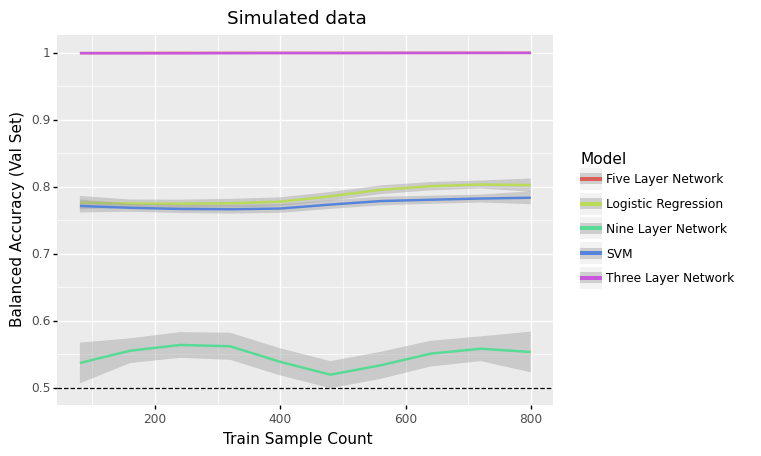

<ggplot: (8773773228097)>

In [11]:
plot_df = tissue_metrics
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Simulated data')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sim_data.svg')
plot

In [54]:
in_files = glob.glob('../../results/sim-data-signal-removed.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/sim-data-signal-removed.pytorch_supervised_1.tsv', '../../results/sim-data-signal-removed.pytorch_lr_2.tsv', '../../results/sim-data-signal-removed.pytorch_supervised_2.tsv', '../../results/sim-data-signal-removed.pytorch_supervised_0.tsv', '../../results/sim-data-signal-removed.deep_net_1.tsv']


In [55]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data-signal-removed.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'Five Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_lr', 'Logistic Regression')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_svm', 'SVM')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('nine_layer_net', 'Nine Layer Network')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sim_data_signal_removed.svg


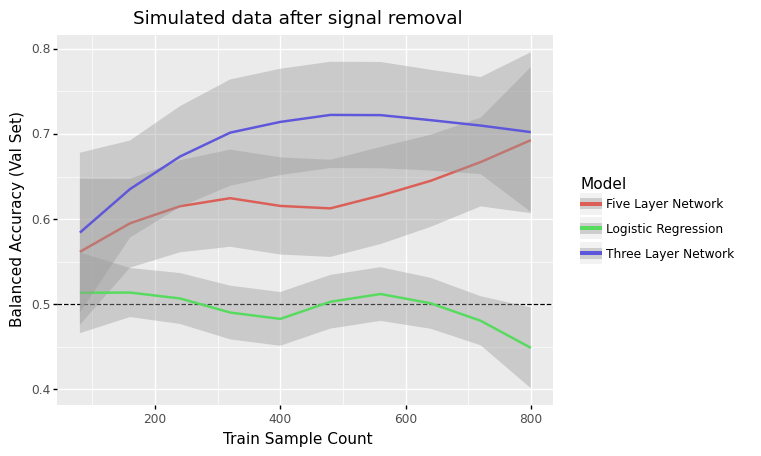

<ggplot: (8772531587957)>

In [56]:
plot_df = tissue_metrics
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated data after signal removal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sim_data_signal_removed.svg')
plot

In [57]:
in_files = glob.glob('../../results/no-signal-sim-data.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/no-signal-sim-data.deep_net_0.tsv', '../../results/no-signal-sim-data.pytorch_supervised_2.tsv', '../../results/no-signal-sim-data.pytorch_supervised_0.tsv', '../../results/no-signal-sim-data.deep_net_2.tsv', '../../results/no-signal-sim-data.pytorch_lr_2.tsv']


In [58]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'Five Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_lr', 'Logistic Regression')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_svm', 'SVM')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('nine_layer_net', 'Nine Layer Network')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/no_signal_sim.svg


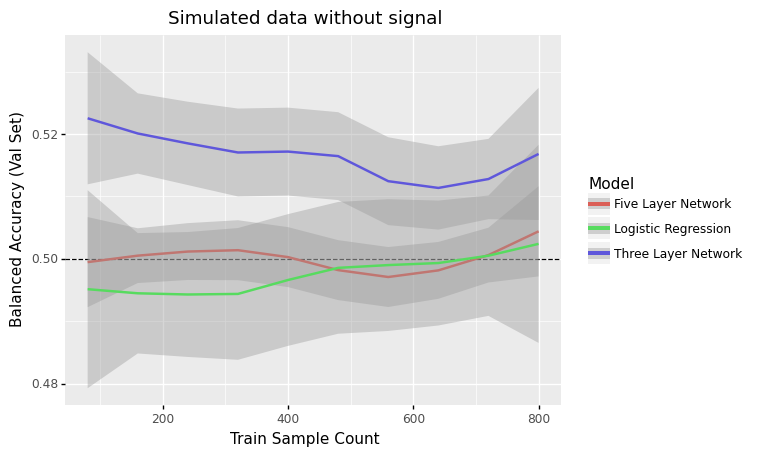

<ggplot: (8772523899873)>

In [59]:
plot_df = tissue_metrics
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated data without signal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/no_signal_sim.svg')
plot

In [60]:
in_files = glob.glob('../../results/no-signal-sim-data-signal-removed.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/no-signal-sim-data-signal-removed.pytorch_lr_1.tsv', '../../results/no-signal-sim-data-signal-removed.pytorch_lr_0.tsv', '../../results/no-signal-sim-data-signal-removed.deep_net_1.tsv', '../../results/no-signal-sim-data-signal-removed.deep_net_0.tsv', '../../results/no-signal-sim-data-signal-removed.deep_net_2.tsv']


In [61]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data-signal-removed.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1]) 
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'Five Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_lr', 'Logistic Regression')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_svm', 'SVM')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('nine_layer_net', 'Nine Layer Network')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/no_signal_sim_signal_removed.svg


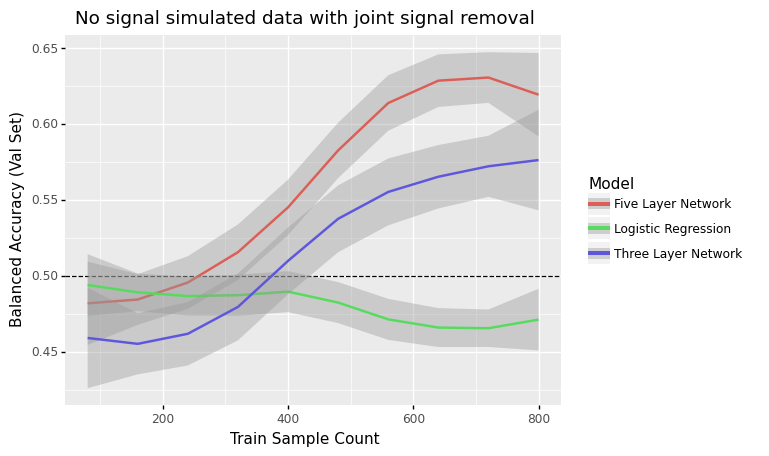

<ggplot: (8772523883581)>

In [62]:
plot_df = tissue_metrics
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('No signal simulated data with joint signal removal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/no_signal_sim_signal_removed.svg')
plot

In [63]:
in_files = glob.glob('../../results/no-signal-sim-data-split-signal.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/no-signal-sim-data-split-signal.pytorch_lr_1.tsv', '../../results/no-signal-sim-data-split-signal.pytorch_supervised_2.tsv', '../../results/no-signal-sim-data-split-signal.pytorch_lr_0.tsv', '../../results/no-signal-sim-data-split-signal.pytorch_supervised_0.tsv', '../../results/no-signal-sim-data-split-signal.pytorch_supervised_1.tsv']


In [64]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data-split-signal.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'Five Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_lr', 'Logistic Regression')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_svm', 'SVM')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('nine_layer_net', 'Nine Layer Network')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/no_signal_sim_split_signal.svg


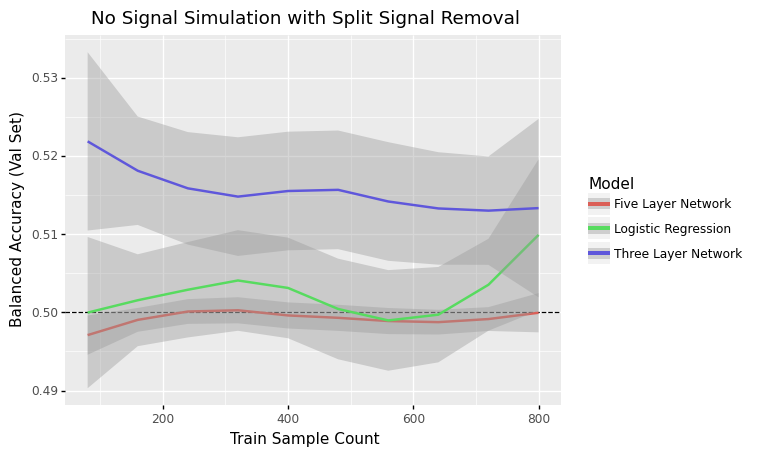

<ggplot: (8772524361389)>

In [65]:
plot_df = tissue_metrics
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('No Signal Simulation with Split Signal Removal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/no_signal_sim_split_signal.svg')
plot

## Linear signal only simulation

In [66]:
in_files = glob.glob('../../results/linear-sim-data.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/linear-sim-data.pytorch_lr_2.tsv', '../../results/linear-sim-data.pytorch_supervised_0.tsv', '../../results/linear-sim-data.pytorch_lr_1.tsv', '../../results/linear-sim-data.pytorch_supervised_1.tsv', '../../results/linear-sim-data.pytorch_lr_0.tsv']


In [67]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('linear-sim-data.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'Five Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_lr', 'Logistic Regression')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_svm', 'SVM')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('nine_layer_net', 'Nine Layer Network')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/linear_sim.svg


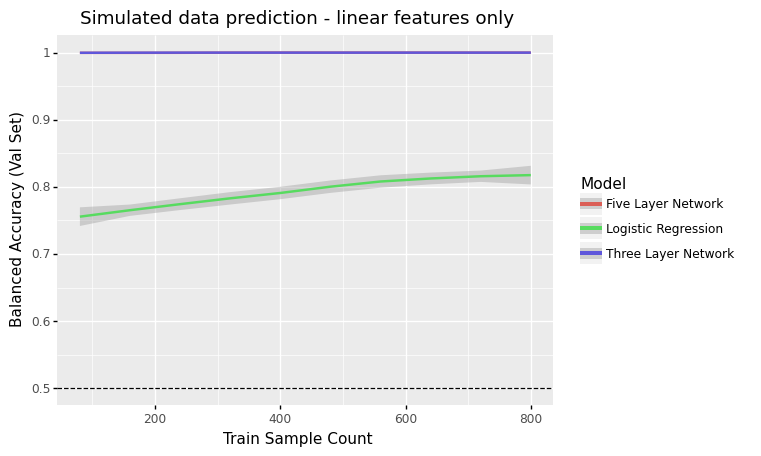

<ggplot: (8772523961885)>

In [68]:
plot_df = tissue_metrics
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated data prediction - linear features only')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/linear_sim.svg')
plot

In [69]:
in_files = glob.glob('../../results/linear-sim-data-signal-removed.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/linear-sim-data-signal-removed.deep_net_0.tsv', '../../results/linear-sim-data-signal-removed.deep_net_1.tsv', '../../results/linear-sim-data-signal-removed.deep_net_2.tsv', '../../results/linear-sim-data-signal-removed.pytorch_lr_0.tsv', '../../results/linear-sim-data-signal-removed.pytorch_lr_1.tsv']


In [70]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data-signal-removed.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'Five Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_lr', 'Logistic Regression')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_svm', 'SVM')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('nine_layer_net', 'Nine Layer Network')
tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,Model,seed,train_count
0,0.480,0.498990,"sample_356_study,sample_403_study,sample_13_st...","sample_489,sample_561,sample_503,sample_192,sa...","sample_1,sample_3,sample_4,sample_8,sample_12,...",80,0.1,"0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,1,1,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",Five Layer Network,0,80
1,0.450,0.479798,"sample_770_study,sample_170_study,sample_29_st...","sample_489,sample_561,sample_503,sample_192,sa...","sample_1,sample_3,sample_4,sample_8,sample_12,...",160,0.2,"0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",Five Layer Network,0,160
2,0.545,0.497475,"sample_770_study,sample_23_study,sample_170_st...","sample_489,sample_561,sample_503,sample_192,sa...","sample_1,sample_3,sample_4,sample_8,sample_12,...",240,0.3,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",Five Layer Network,0,240
3,0.435,0.482323,"sample_781_study,sample_178_study,sample_894_s...","sample_489,sample_561,sample_503,sample_192,sa...","sample_1,sample_3,sample_4,sample_8,sample_12,...",320,0.4,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",Five Layer Network,0,320
4,0.560,0.528283,"sample_781_study,sample_178_study,sample_894_s...","sample_489,sample_561,sample_503,sample_192,sa...","sample_1,sample_3,sample_4,sample_8,sample_12,...",400,0.5,"1,0,0,1,0,0,0,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",Five Layer Network,0,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.495,0.500000,"sample_282_study,sample_321_study,sample_608_s...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",480,0.6,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",Three Layer Network,0,480
46,0.505,0.500000,"sample_282_study,sample_321_study,sample_608_s...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",560,0.7,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",Three Layer Network,0,560
47,0.505,0.500000,"sample_282_study,sample_321_study,sample_608_s...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",640,0.8,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",Three Layer Network,0,640
48,0.495,0.500000,"sample_282_study,sample_321_study,sample_608_s...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",720,0.9,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",Three Layer Network,0,720


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/linear_sim_signal_removed.svg


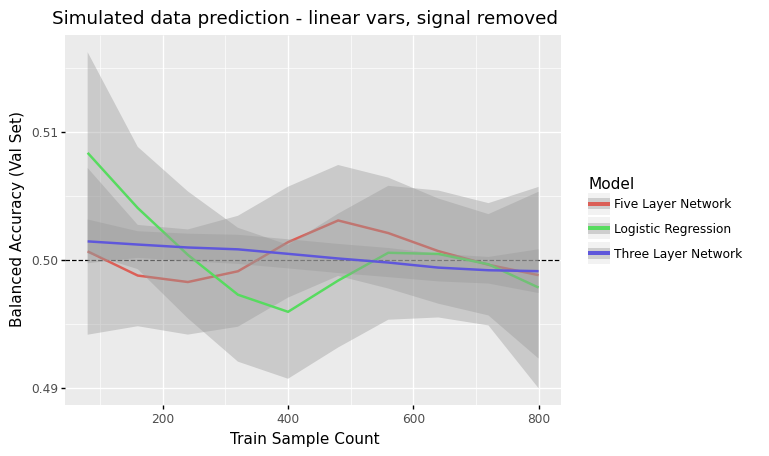

<ggplot: (8772531480085)>

In [71]:
plot_df = tissue_metrics
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated data prediction - linear vars, signal removed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/linear_sim_signal_removed.svg')
plot

### Combined Sim Figure

In [72]:
in_files = glob.glob('../../results/linear-sim*.tsv')
in_files.extend(glob.glob('../../results/no-signal-sim*.tsv'))
in_files.extend(glob.glob('../../results/sim-data*.tsv'))

In [73]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    if 'linear-sim-data-signal-removed.' in path:
        model_info = path.strip('.tsv').split('linear-sim-data-signal-removed.')[-1]
        new_df['Correction'] = 'Signal Removed'
        new_df['simulation'] = 'Linear Sim'
    elif 'linear-sim-data.' in path:
        model_info = path.strip('.tsv').split('linear-sim-data.')[-1]
        new_df['Correction'] = 'Full Signal'
        new_df['simulation'] = 'Linear Sim'
    elif '/sim-data.' in path:
        model_info = path.strip('.tsv').split('sim-data.')[-1]
        new_df['Correction'] = 'Full Signal'
        new_df['simulation'] = 'Nonlinear Sim'
    elif '/sim-data-signal-removed.' in path:
        model_info = path.strip('.tsv').split('sim-data-signal-removed.')[-1]
        new_df['Correction'] = 'Signal Removed'
        new_df['simulation'] = 'Nonlinear Sim'
    elif 'no-signal-sim-data.' in path:
        model_info = path.strip('.tsv').split('no-signal-sim-data.')[-1]
        new_df['Correction'] = 'Full Signal'
        new_df['simulation'] = 'Random Sim'
    elif 'no-signal-sim-data-split-signal.' in path:
        model_info = path.strip('.tsv').split('no-signal-sim-data-split-signal.')[-1]
        new_df['Correction'] = 'Signal Removed'
        new_df['simulation'] = 'Random Sim'
    else:
        continue
    model_info = model_info.split('_')    
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'Five Layer Network')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_lr', 'Logistic Regression')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_svm', 'SVM')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('nine_layer_net', 'Nine Layer Network')

## Out of dataset generalization

### Recount to GTEx Binary

In [74]:
top_five_tissues = ['Blood', 'Breast', 'Brain', 'Kidney', 'Lung']

combo_iterator = itertools.combinations(top_five_tissues, 2)
tissue_pairs = [pair for pair in combo_iterator]
tissue_pairs[:3]

[('Blood', 'Breast'), ('Blood', 'Brain'), ('Blood', 'Kidney')]

In [75]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/recount_transfer.{}.{}.*.tsv'.format(pair[0], pair[1])))
len(in_files)

90

In [76]:
run_results = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
    
    tissue1 = run_info[1]
    tissue2 = run_info[2]
    
    model_and_seed = run_info[3].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
    
    correction_method = 'unmodified'
    if 'signal_removed' in path:
        if 'sample_level' in path:
            correction_method = 'signal_removed_sample_level'
        else:
            correction_method = 'signal_removed'
    elif 'study_corrected' in path:
        correction_method = 'study_corrected'
    elif 'split_signal' in path:
        correction_method = 'split_signal'
    
    new_df['Model'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['correction_method'] = correction_method
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    run_results = pd.concat([run_results, new_df])
    
run_results['train_count'] = run_results['train sample count']
run_results['Model'] = run_results['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
run_results['Model'] = run_results['Model'].str.replace('deep_net', 'Five Layer Network')
run_results['Model'] = run_results['Model'].str.replace('pytorch_lr', 'Logistic Regression')

In [77]:
reformatted_results = run_results.melt(id_vars=['Model', 'tissue1', 'tissue2'], 
                                       value_vars=['balanced_accuracy', 'transfer_balanced_accuracy'])
reformatted_results = reformatted_results.rename({'variable': 'Domain', 'value': 'balanced_accuracy'}, axis='columns')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('transfer_balanced_accuracy', 'target')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('balanced_accuracy', 'source')

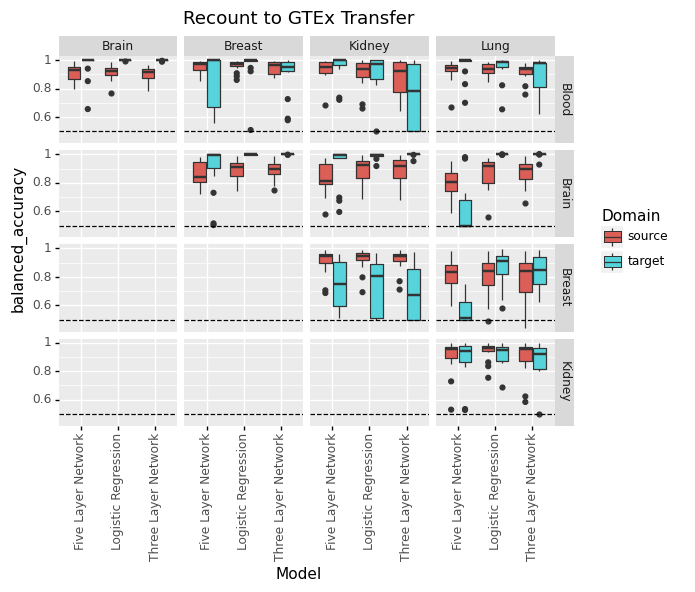

<ggplot: (8772573164429)>


In [78]:
plot = ggplot(reformatted_results, aes(x='Model', y='balanced_accuracy', fill='Domain'))
plot += geom_boxplot()
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Recount to GTEx Transfer')
print(plot)

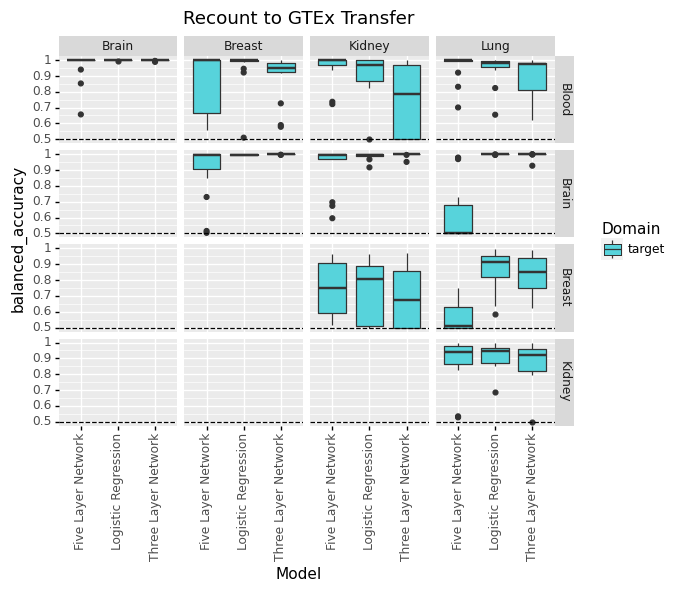

<ggplot: (8772531386641)>


In [79]:
plot = ggplot(reformatted_results[reformatted_results['Domain'] == 'target'], aes(x='Model', y='balanced_accuracy', fill='Domain'))
plot += geom_boxplot()
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += scale_fill_manual(values=['#57d3db'])
plot += ggtitle('Recount to GTEx Transfer')
print(plot)

### Recount to GTEx Binary Signal Removed

In [80]:
top_five_tissues = ['Blood', 'Breast', 'Brain', 'Kidney', 'Lung']

combo_iterator = itertools.combinations(top_five_tissues, 2)
tissue_pairs = [pair for pair in combo_iterator]
tissue_pairs[:3]

[('Blood', 'Breast'), ('Blood', 'Brain'), ('Blood', 'Kidney')]

In [81]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/recount_transfer.split_signal.{}.{}.*.tsv'.format(pair[0], pair[1])))
len(in_files)

90

In [82]:
run_results = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
    
    tissue1 = run_info[2]
    tissue2 = run_info[3]
    
    model_and_seed = run_info[4].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
    
    correction_method = 'unmodified'
    if 'signal_removed' in path:
        if 'sample_level' in path:
            correction_method = 'signal_removed_sample_level'
        else:
            correction_method = 'signal_removed'
    elif 'study_corrected' in path:
        correction_method = 'study_corrected'
    elif 'split_signal' in path:
        correction_method = 'split_signal'
    
    new_df['Model'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['correction_method'] = correction_method
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    run_results = pd.concat([run_results, new_df])
    
run_results['train_count'] = run_results['train sample count']
run_results['Model'] = run_results['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
run_results['Model'] = run_results['Model'].str.replace('deep_net', 'Five Layer Network')
run_results['Model'] = run_results['Model'].str.replace('pytorch_lr', 'Logistic Regression')

In [83]:
reformatted_results = run_results.melt(id_vars=['Model', 'tissue1', 'tissue2'], 
                                       value_vars=['balanced_accuracy', 'transfer_balanced_accuracy'])
reformatted_results = reformatted_results.rename({'variable': 'Domain', 'value': 'balanced_accuracy'}, axis='columns')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('transfer_balanced_accuracy', 'target')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('balanced_accuracy', 'source')

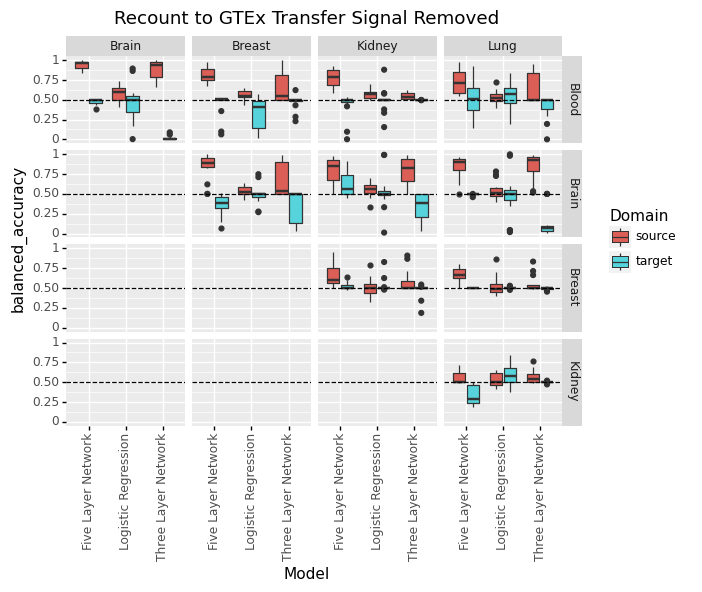

<ggplot: (8772531265489)>


In [84]:
plot = ggplot(reformatted_results, aes(x='Model', y='balanced_accuracy', fill='Domain'))
plot += geom_boxplot()
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Recount to GTEx Transfer Signal Removed')
print(plot)

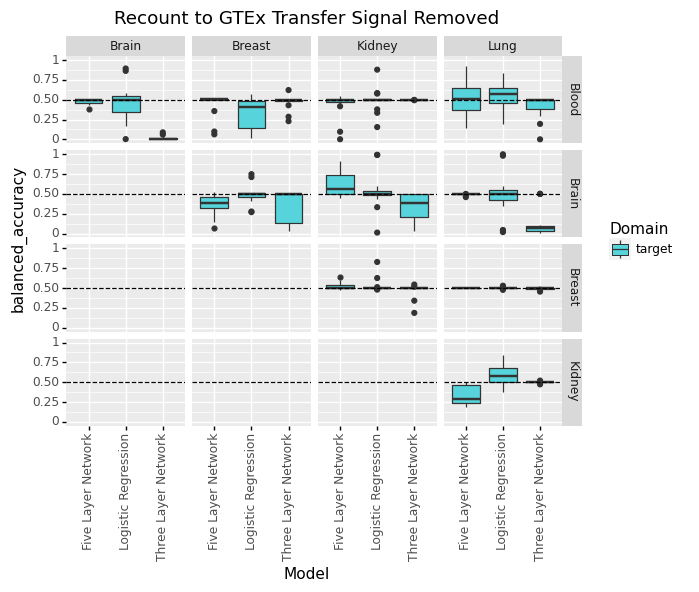

<ggplot: (8772524157013)>


In [85]:
plot = ggplot(reformatted_results[reformatted_results['Domain'] == 'target'], aes(x='Model', y='balanced_accuracy', fill='Domain'))
plot += geom_boxplot()
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += scale_fill_manual(values=['#57d3db'])
plot += ggtitle('Recount to GTEx Transfer Signal Removed')
print(plot)

### GTEx to Recount Transfer

In [86]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/gtex_transfer.{}.{}.*.tsv'.format(pair[0], pair[1])))
len(in_files)

90

In [87]:
run_results = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
    
    tissue1 = run_info[1]
    tissue2 = run_info[2]
    
    model_and_seed = run_info[3].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
    
    correction_method = 'unmodified'
    if 'signal_removed' in path:
        if 'sample_level' in path:
            correction_method = 'signal_removed_sample_level'
        else:
            correction_method = 'signal_removed'
    elif 'study_corrected' in path:
        correction_method = 'study_corrected'
    elif 'split_signal' in path:
        correction_method = 'split_signal'
    
    new_df['Model'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['correction_method'] = correction_method
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    run_results = pd.concat([run_results, new_df])
    
run_results['train_count'] = run_results['train sample count']
run_results['Model'] = run_results['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
run_results['Model'] = run_results['Model'].str.replace('deep_net', 'Five Layer Network')
run_results['Model'] = run_results['Model'].str.replace('pytorch_lr', 'Logistic Regression')

In [88]:
reformatted_results = run_results.melt(id_vars=['Model', 'tissue1', 'tissue2'], 
                                       value_vars=['balanced_accuracy', 'transfer_balanced_accuracy'])
reformatted_results = reformatted_results.rename({'variable': 'Domain', 'value': 'balanced_accuracy'}, axis='columns')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('transfer_balanced_accuracy', 'target')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('balanced_accuracy', 'source')
reformatted_results

,Model,tissue1,tissue2,Domain,balanced_accuracy
0,Three Layer Network,Blood,Breast,source,1.000000
1,Three Layer Network,Blood,Breast,source,1.000000
2,Three Layer Network,Blood,Breast,source,1.000000
3,Three Layer Network,Blood,Breast,source,1.000000
4,Three Layer Network,Blood,Breast,source,1.000000
...,...,...,...,...,...
895,Three Layer Network,Kidney,Lung,target,0.734615
896,Three Layer Network,Kidney,Lung,target,0.759300
897,Three Layer Network,Kidney,Lung,target,0.751218
898,Three Layer Network,Kidney,Lung,target,0.747409


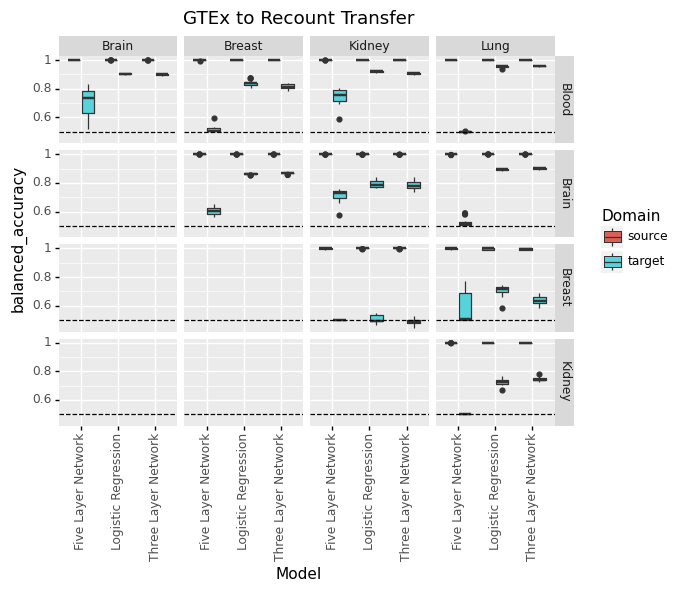

<ggplot: (8772523902173)>


In [89]:
plot = ggplot(reformatted_results, aes(x='Model', y='balanced_accuracy', fill='Domain'))
plot += geom_boxplot()
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('GTEx to Recount Transfer')
print(plot)

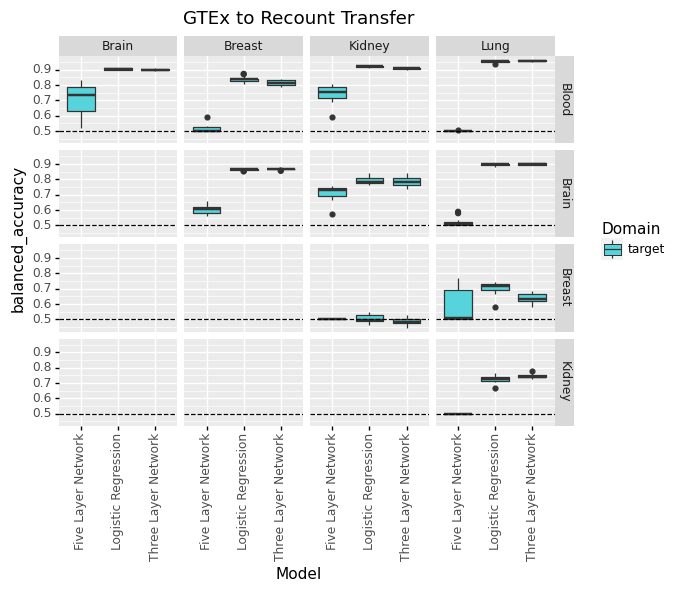

<ggplot: (8772524544805)>


In [90]:
plot = ggplot(reformatted_results[reformatted_results['Domain'] == 'target'], aes(x='Model', y='balanced_accuracy', fill='Domain'))
plot += geom_boxplot()
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += scale_fill_manual(values=['#57d3db'])
plot += ggtitle('GTEx to Recount Transfer')
print(plot)

### GTEx to Recount Transfer Signal Removed

In [91]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/gtex_transfer.split_signal.{}.{}.*.tsv'.format(pair[0], pair[1])))
len(in_files)

90

In [92]:
run_results = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
    
    tissue1 = run_info[2]
    tissue2 = run_info[3]
    
    model_and_seed = run_info[4].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
    
    correction_method = 'unmodified'
    if 'signal_removed' in path:
        if 'sample_level' in path:
            correction_method = 'signal_removed_sample_level'
        else:
            correction_method = 'signal_removed'
    elif 'study_corrected' in path:
        correction_method = 'study_corrected'
    elif 'split_signal' in path:
        correction_method = 'split_signal'
    
    new_df['Model'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['correction_method'] = correction_method
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    run_results = pd.concat([run_results, new_df])
    
run_results['train_count'] = run_results['train sample count']
run_results['Model'] = run_results['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
run_results['Model'] = run_results['Model'].str.replace('deep_net', 'Five Layer Network')
run_results['Model'] = run_results['Model'].str.replace('pytorch_lr', 'Logistic Regression')

In [93]:
reformatted_results = run_results.melt(id_vars=['Model', 'tissue1', 'tissue2'], 
                                       value_vars=['balanced_accuracy', 'transfer_balanced_accuracy'])
reformatted_results = reformatted_results.rename({'variable': 'Domain', 'value': 'balanced_accuracy'}, axis='columns')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('transfer_balanced_accuracy', 'target')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('balanced_accuracy', 'source')
reformatted_results

,Model,tissue1,tissue2,Domain,balanced_accuracy
0,Logistic Regression,Blood,Breast,source,0.505682
1,Logistic Regression,Blood,Breast,source,0.509804
2,Logistic Regression,Blood,Breast,source,0.577941
3,Logistic Regression,Blood,Breast,source,0.500000
4,Logistic Regression,Blood,Breast,source,0.500000
...,...,...,...,...,...
895,Logistic Regression,Kidney,Lung,target,0.536306
896,Logistic Regression,Kidney,Lung,target,0.548400
897,Logistic Regression,Kidney,Lung,target,0.519868
898,Logistic Regression,Kidney,Lung,target,0.521739


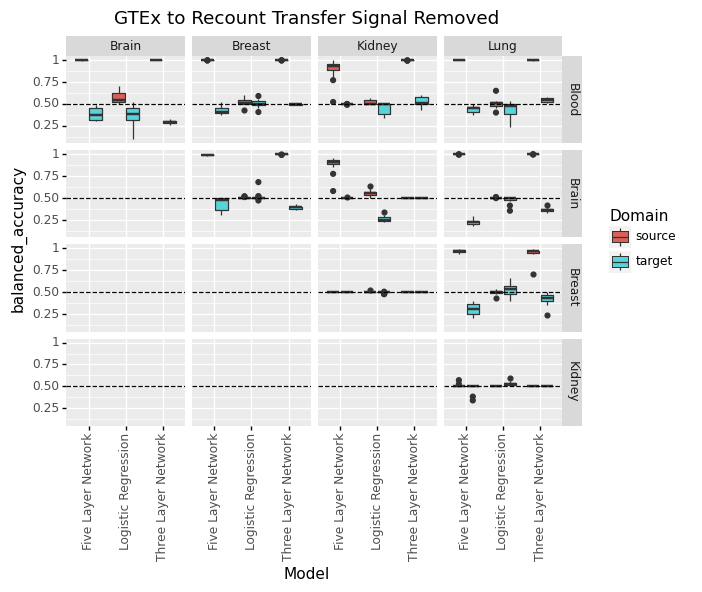

<ggplot: (8772524671777)>


In [94]:
plot = ggplot(reformatted_results, aes(x='Model', y='balanced_accuracy', fill='Domain'))
plot += geom_boxplot()
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('GTEx to Recount Transfer Signal Removed')
print(plot)

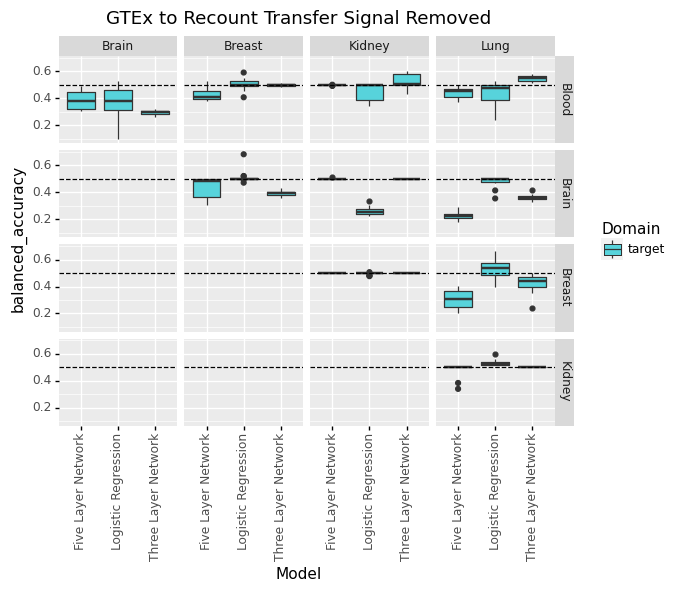

<ggplot: (8772530988505)>


In [95]:
plot = ggplot(reformatted_results[reformatted_results['Domain'] == 'target'], aes(x='Model', y='balanced_accuracy', fill='Domain'))
plot += geom_boxplot()
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += scale_fill_manual(values=['#57d3db'])
plot += ggtitle('GTEx to Recount Transfer Signal Removed')
print(plot)

### Recount to GTEx All Tissue Transfer

In [96]:
in_files = glob.glob('../../results/recount-transfer.all-tissue.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/recount-transfer.all-tissue.pytorch_supervised_1.tsv', '../../results/recount-transfer.all-tissue.pytorch_supervised_2.tsv', '../../results/recount-transfer.all-tissue.deep_net_0.tsv', '../../results/recount-transfer.all-tissue.pytorch_lr_0.tsv', '../../results/recount-transfer.all-tissue.deep_net_2.tsv']


In [97]:
recount_multiclass_transfer_df = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    recount_multiclass_transfer_df = pd.concat([recount_multiclass_transfer_df, new_df])
    
recount_multiclass_transfer_df['train_count'] = recount_multiclass_transfer_df['train sample count']

recount_multiclass_transfer_df['Model'] = recount_multiclass_transfer_df['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
recount_multiclass_transfer_df['Model'] = recount_multiclass_transfer_df['Model'].str.replace('deep_net', 'Five Layer Network')
recount_multiclass_transfer_df['Model'] = recount_multiclass_transfer_df['Model'].str.replace('pytorch_lr', 'Logistic Regression')

In [98]:
reformatted_results = recount_multiclass_transfer_df.melt(id_vars=['Model'], 
                                                          value_vars=['balanced_accuracy', 'transfer_balanced_accuracy'])
reformatted_results = reformatted_results.rename({'variable': 'Domain', 'value': 'balanced_accuracy'}, axis='columns')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('transfer_balanced_accuracy', 'target')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('balanced_accuracy', 'source')
reformatted_results

,Model,Domain,balanced_accuracy
0,Three Layer Network,source,0.815040
1,Three Layer Network,source,0.546871
2,Three Layer Network,source,0.757042
3,Three Layer Network,source,0.471631
4,Three Layer Network,source,0.655737
...,...,...,...
85,Three Layer Network,target,0.400484
86,Three Layer Network,target,0.657519
87,Three Layer Network,target,0.627673
88,Three Layer Network,target,0.711324


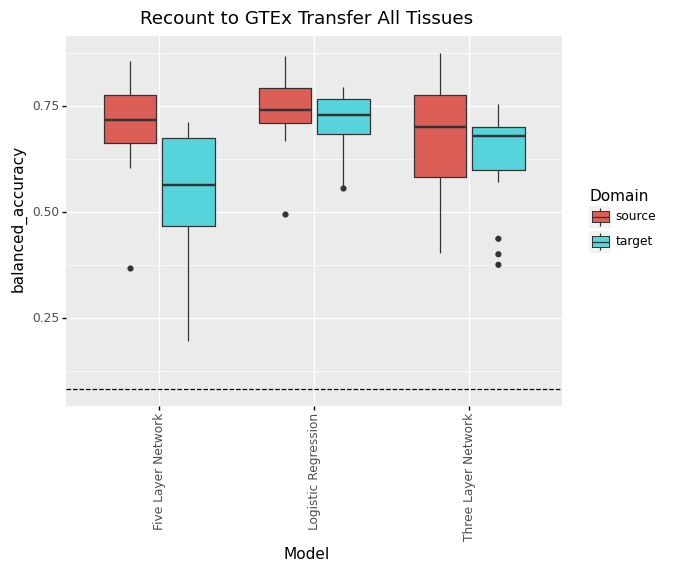

<ggplot: (8772529685121)>


In [99]:
plot = ggplot(reformatted_results, aes(x='Model', y='balanced_accuracy', fill='Domain'))
plot += geom_boxplot()
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot += geom_hline(yintercept=1/12, linetype='dashed')
plot += ggtitle('Recount to GTEx Transfer All Tissues')
print(plot)

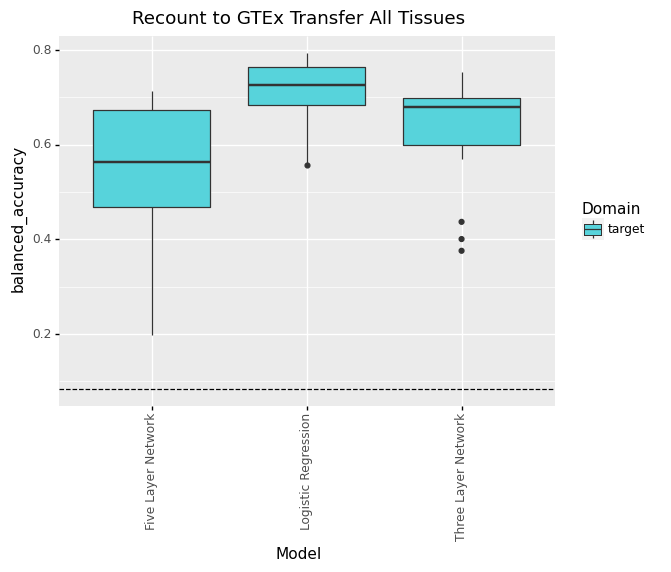

<ggplot: (8772524033449)>


In [100]:
plot = ggplot(reformatted_results[reformatted_results['Domain'] == 'target'], aes(x='Model', y='balanced_accuracy', fill='Domain'))
plot += geom_boxplot()
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot += geom_hline(yintercept=1/12, linetype='dashed')
plot += scale_fill_manual(values=['#57d3db'])
plot += ggtitle('Recount to GTEx Transfer All Tissues')
print(plot)

### Recount to GTEx All Tissue Transfer Signal Removed

In [101]:
in_files = glob.glob('../../results/recount-transfer.split-signal.all-tissue.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/recount-transfer.split-signal.all-tissue.pytorch_supervised_1.tsv', '../../results/recount-transfer.split-signal.all-tissue.deep_net_0.tsv', '../../results/recount-transfer.split-signal.all-tissue.deep_net_2.tsv', '../../results/recount-transfer.split-signal.all-tissue.pytorch_supervised_0.tsv', '../../results/recount-transfer.split-signal.all-tissue.pytorch_lr_1.tsv']


In [102]:
recount_multiclass_transfer_df = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    recount_multiclass_transfer_df = pd.concat([recount_multiclass_transfer_df, new_df])
    
recount_multiclass_transfer_df['train_count'] = recount_multiclass_transfer_df['train sample count']

recount_multiclass_transfer_df['Model'] = recount_multiclass_transfer_df['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
recount_multiclass_transfer_df['Model'] = recount_multiclass_transfer_df['Model'].str.replace('deep_net', 'Five Layer Network')
recount_multiclass_transfer_df['Model'] = recount_multiclass_transfer_df['Model'].str.replace('pytorch_lr', 'Logistic Regression')

In [103]:
reformatted_results = recount_multiclass_transfer_df.melt(id_vars=['Model'], 
                                                          value_vars=['balanced_accuracy', 'transfer_balanced_accuracy'])
reformatted_results = reformatted_results.rename({'variable': 'Domain', 'value': 'balanced_accuracy'}, axis='columns')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('transfer_balanced_accuracy', 'target')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('balanced_accuracy', 'source')
reformatted_results

,Model,Domain,balanced_accuracy
0,Three Layer Network,source,0.277964
1,Three Layer Network,source,0.116164
2,Three Layer Network,source,0.416513
3,Three Layer Network,source,0.101480
4,Three Layer Network,source,0.472712
...,...,...,...
85,Logistic Regression,target,0.094724
86,Logistic Regression,target,0.104980
87,Logistic Regression,target,0.163118
88,Logistic Regression,target,0.191288


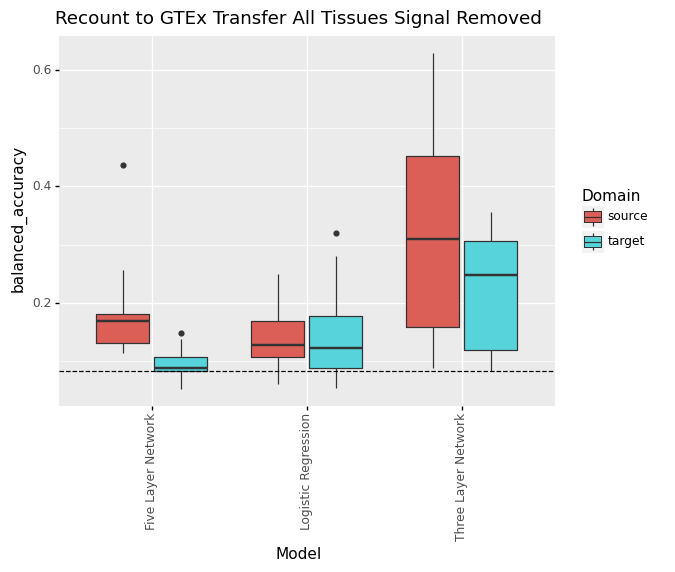

<ggplot: (8772531550117)>


In [104]:
plot = ggplot(reformatted_results, aes(x='Model', y='balanced_accuracy', fill='Domain'))
plot += geom_boxplot()
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot += geom_hline(yintercept=1/12, linetype='dashed')
plot += ggtitle('Recount to GTEx Transfer All Tissues Signal Removed')
print(plot)

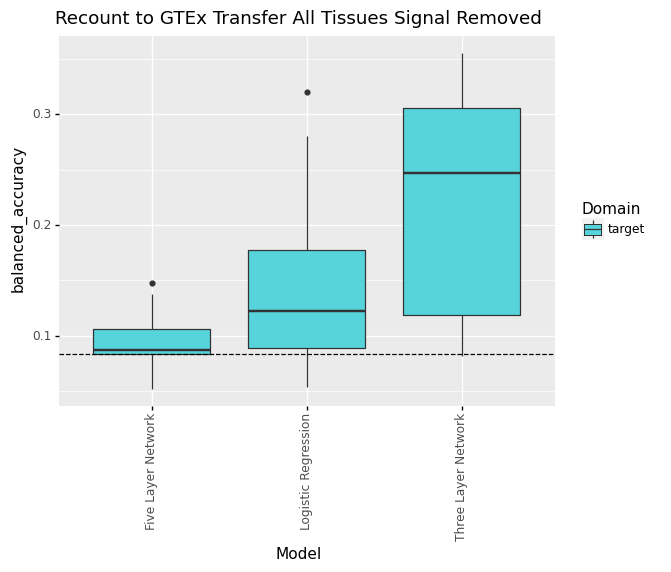

<ggplot: (8772531166425)>


In [105]:
plot = ggplot(reformatted_results[reformatted_results['Domain'] == 'target'], aes(x='Model', y='balanced_accuracy', fill='Domain'))
plot += geom_boxplot()
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot += geom_hline(yintercept=1/12, linetype='dashed')
plot += scale_fill_manual(values=['#57d3db'])
plot += ggtitle('Recount to GTEx Transfer All Tissues Signal Removed')
print(plot)

### GTEx to Recount All Transfer

In [106]:
in_files = glob.glob('../../results/gtex-transfer.all-tissue.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/gtex-transfer.all-tissue.pytorch_supervised_1.tsv', '../../results/gtex-transfer.all-tissue.deep_net_1.tsv', '../../results/gtex-transfer.all-tissue.pytorch_lr_2.tsv', '../../results/gtex-transfer.all-tissue.deep_net_0.tsv', '../../results/gtex-transfer.all-tissue.pytorch_lr_0.tsv']


In [107]:
gtex_multiclass_transfer_df = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    gtex_multiclass_transfer_df = pd.concat([gtex_multiclass_transfer_df, new_df])
    
gtex_multiclass_transfer_df['train_count'] = gtex_multiclass_transfer_df['train sample count']

gtex_multiclass_transfer_df['Model'] = gtex_multiclass_transfer_df['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
gtex_multiclass_transfer_df['Model'] = gtex_multiclass_transfer_df['Model'].str.replace('deep_net', 'Five Layer Network')
gtex_multiclass_transfer_df['Model'] = gtex_multiclass_transfer_df['Model'].str.replace('pytorch_lr', 'Logistic Regression')

In [108]:
reformatted_results = gtex_multiclass_transfer_df.melt(id_vars=['Model'], 
                                                          value_vars=['balanced_accuracy', 'transfer_balanced_accuracy'])
reformatted_results = reformatted_results.rename({'variable': 'Domain', 'value': 'balanced_accuracy'}, axis='columns')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('transfer_balanced_accuracy', 'target')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('balanced_accuracy', 'source')
reformatted_results

,Model,Domain,balanced_accuracy
0,Three Layer Network,source,0.994611
1,Three Layer Network,source,0.996250
2,Three Layer Network,source,0.989513
3,Three Layer Network,source,0.990427
4,Three Layer Network,source,0.985166
...,...,...,...
85,Logistic Regression,target,0.556796
86,Logistic Regression,target,0.532198
87,Logistic Regression,target,0.546439
88,Logistic Regression,target,0.521218


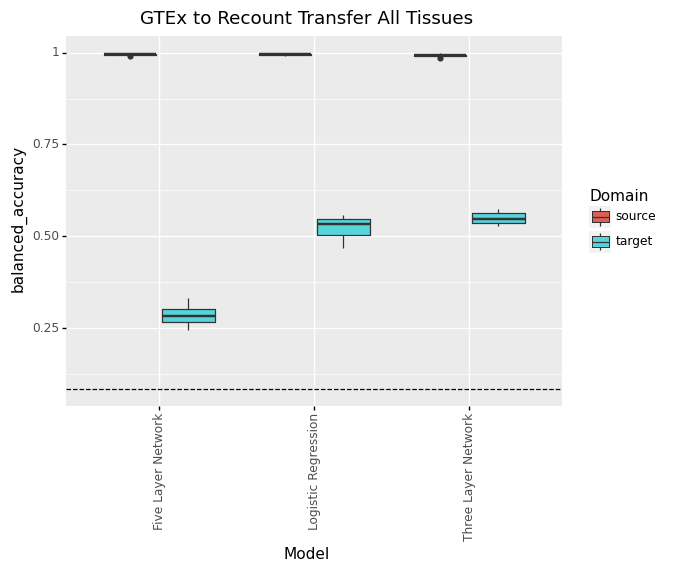

<ggplot: (8772524077105)>


In [109]:
plot = ggplot(reformatted_results, aes(x='Model', y='balanced_accuracy', fill='Domain'))
plot += geom_boxplot()
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot += geom_hline(yintercept=1/12, linetype='dashed')
plot += ggtitle('GTEx to Recount Transfer All Tissues')
print(plot)

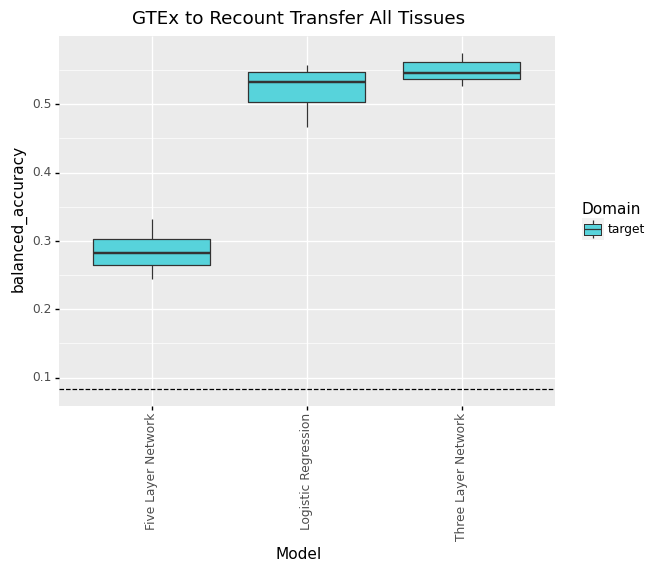

<ggplot: (8772573708853)>


In [110]:
plot = ggplot(reformatted_results[reformatted_results['Domain'] == 'target'], aes(x='Model', y='balanced_accuracy', fill='Domain'))
plot += geom_boxplot()
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot += geom_hline(yintercept=1/12, linetype='dashed')
plot += scale_fill_manual(values=['#57d3db'])
plot += ggtitle('GTEx to Recount Transfer All Tissues')
print(plot)

### GTEx to Recount All Transfer Signal Removed

In [111]:
in_files = glob.glob('../../results/gtex-transfer.split-signal.all-tissue.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/gtex-transfer.split-signal.all-tissue.pytorch_supervised_0.tsv', '../../results/gtex-transfer.split-signal.all-tissue.pytorch_supervised_1.tsv', '../../results/gtex-transfer.split-signal.all-tissue.pytorch_lr_0.tsv', '../../results/gtex-transfer.split-signal.all-tissue.deep_net_2.tsv', '../../results/gtex-transfer.split-signal.all-tissue.pytorch_lr_1.tsv']


In [112]:
gtex_multiclass_transfer_df = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    gtex_multiclass_transfer_df = pd.concat([gtex_multiclass_transfer_df, new_df])
    
gtex_multiclass_transfer_df['train_count'] = gtex_multiclass_transfer_df['train sample count']

gtex_multiclass_transfer_df['Model'] = gtex_multiclass_transfer_df['Model'].str.replace('pytorch_supervised', 'Three Layer Network')
gtex_multiclass_transfer_df['Model'] = gtex_multiclass_transfer_df['Model'].str.replace('deep_net', 'Five Layer Network')
gtex_multiclass_transfer_df['Model'] = gtex_multiclass_transfer_df['Model'].str.replace('pytorch_lr', 'Logistic Regression')

In [113]:
reformatted_results = gtex_multiclass_transfer_df.melt(id_vars=['Model'], 
                                                          value_vars=['balanced_accuracy', 'transfer_balanced_accuracy'])
reformatted_results = reformatted_results.rename({'variable': 'Domain', 'value': 'balanced_accuracy'}, axis='columns')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('transfer_balanced_accuracy', 'target')
reformatted_results['Domain'] = reformatted_results['Domain'].str.replace('balanced_accuracy', 'source')
reformatted_results

,Model,Domain,balanced_accuracy
0,Three Layer Network,source,0.909579
1,Three Layer Network,source,0.923758
2,Three Layer Network,source,0.906078
3,Three Layer Network,source,0.904950
4,Three Layer Network,source,0.905655
...,...,...,...
85,Five Layer Network,target,0.108048
86,Five Layer Network,target,0.118923
87,Five Layer Network,target,0.109606
88,Five Layer Network,target,0.107798


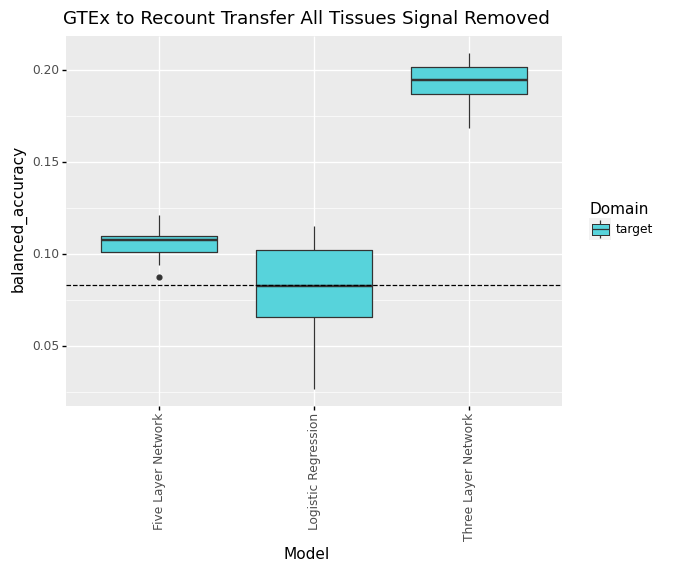

<ggplot: (8772531388777)>


In [114]:
plot = ggplot(reformatted_results[reformatted_results['Domain'] == 'target'], aes(x='Model', y='balanced_accuracy', fill='Domain'))
plot += geom_boxplot()
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot += geom_hline(yintercept=1/12, linetype='dashed')
plot += scale_fill_manual(values=['#57d3db'])
plot += ggtitle('GTEx to Recount Transfer All Tissues Signal Removed')
print(plot)

## Publication Figures

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/simulated_data_combined.svg


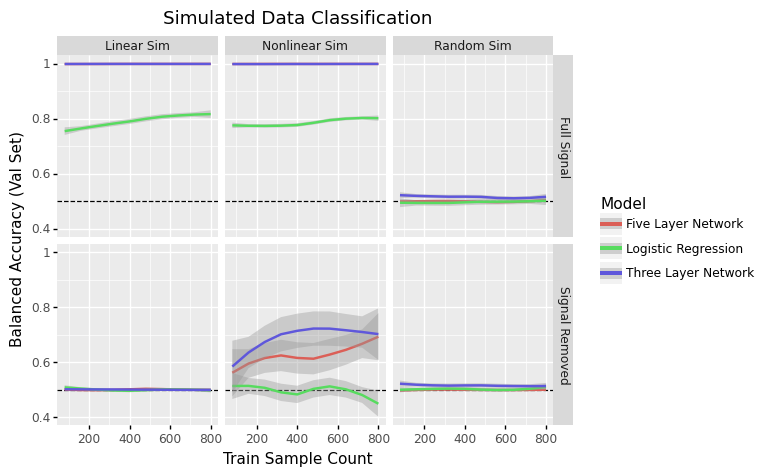

<ggplot: (8772529452573)>

In [115]:
plot_df = tissue_metrics
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated Data Classification')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += facet_grid(['Correction', 'simulation'], scales='fixed')
plot.save('../../figures/simulated_data_combined.svg')
plot

In [116]:
#create new SVG figure
fig = sg.SVGFigure("16cm", "16cm")

# load matpotlib-generated figures
fig1 = sg.fromfile('../../figures/gtex_multiclass_combined.svg')
fig2 = sg.fromfile('../../figures/recount_multiclass_combined.svg')
fig3 = sg.fromfile('../../figures/sex_prediction_combined.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot3 = fig3.getroot()

plot1.moveto(0, 0, scale_x=.5, scale_y=.5)
plot2.moveto(205, 0, scale_x=.5, scale_y=.5)
plot3.moveto(105, 160, scale_x=.5, scale_y=.5)

fig.append([plot1, plot2, plot3])

fig.save('../../figures/signal_removed_multiclass.svg')

In [117]:
#create new SVG figure
fig = sg.SVGFigure("16cm", "16cm")

# load matpotlib-generated figures
fig1 = sg.fromfile('../../figures/gtex_binary_combined.svg')
fig2 = sg.fromfile('../../figures/recount_binary_combined.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()

plot1.moveto(0, 0, scale_x=.5, scale_y=.5)
plot2.moveto(205, 0, scale_x=.5, scale_y=.5)

fig.append([plot1, plot2])

fig.save('../../figures/signal_removed_binary.svg')